# Recurrent Neural Networks

Grzegorz Statkiewicz, Mateusz Matukiewicz

## Overview

The structure of the direcotry should be as follows:

```
.
├── data
│   ├── train.pkl
│   └── test_no_target.pkl
└── main.ipynb
```



## Setup

Select the device to use

In [1]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


## Data preparation

Load the data

In [2]:
train_path = "data/train.pkl"

In [3]:
import pickle

with open(train_path, "rb") as f:
    train_data = pickle.load(f)

print(f"Loaded {len(train_data)} training samples.")

Loaded 2939 training samples.


Determine the compositors

In [4]:
compositors = {0: 'bach', 1: 'beethoven', 2: 'debussy', 3: 'scarlatti', 4: 'victoria'}
num_classes = len(compositors)

Determine the vocab size

In [5]:
import numpy as np

sequences = [torch.tensor(seq, dtype=torch.long) for (seq, label) in train_data]
labels = [label for (seq, label) in train_data]

# Find the max chord index (vocab size, since chords are ints)
all_chords = set()
for seq in sequences:
    all_chords.update(seq.tolist())
vocab_size = int(max(all_chords)) + 2  # +1 for max, +1 for padding idx=0

print(f"Vocab size: {vocab_size}")

Vocab size: 193


Prepare the train and test datasets

In [6]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class ChordDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

def collate_fn(batch):
    seqs, labels = zip(*batch)
    lengths = torch.tensor([len(s) for s in seqs], dtype=torch.long)
    padded_seqs = pad_sequence(seqs, batch_first=True, padding_value=0)
    return padded_seqs, lengths, torch.tensor(labels, dtype=torch.long)

In [7]:
from sklearn.model_selection import train_test_split

BATCH_SIZE = 256

train_data_split, val_data_split = train_test_split(train_data, test_size=0.2, random_state=42)

train_sequences = [torch.tensor(seq, dtype=torch.long) for (seq, label) in train_data_split]
train_labels = [label for (seq, label) in train_data_split]
val_sequences = [torch.tensor(seq, dtype=torch.long) for (seq, label) in val_data_split]
val_labels = [label for (seq, label) in val_data_split]

train_dataset = ChordDataset(train_sequences, train_labels)
val_dataset = ChordDataset(val_sequences, val_labels)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


In [8]:
from torch.utils.data import WeightedRandomSampler

class_sample_counts = np.array([train_labels.count(i) for i in range(num_classes)])
weights = 1. / class_sample_counts

sample_weights = np.array([weights[label] for label in train_labels])
sample_weights = torch.DoubleTensor(sample_weights)

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

sampled_train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, collate_fn=collate_fn)

## Create the model

In [9]:
import torch.nn as nn

class SimpleRNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, dropout_p=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x, lengths):
        x = self.embedding(x)
        x = self.dropout(x)
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, h_n = self.rnn(packed)
        h_n = self.dropout(h_n[-1])
        logits = self.fc(h_n)
        return logits

## Train the model

In [ ]:
from training import Trainer

### Without sampling, weight balancing

In [11]:
EMBED_DIM = 32
HIDDEN_DIM = 64
DROPOUT_P = 0.2

wb_model = SimpleRNNClassifier(vocab_size, EMBED_DIM, HIDDEN_DIM, num_classes, DROPOUT_P).to(device)

In [12]:
counts = torch.tensor([1630, 478, 154, 441, 236], dtype=torch.float)
class_weights = 1.0 / counts
class_weights = class_weights / class_weights.sum() * len(counts)  # Normalize to num_classes

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

In [13]:
optimizer = torch.optim.Adam(wb_model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

trainer = Trainer(wb_model, criterion, optimizer, scheduler=scheduler, device=device)

Perfrom training on the default trianing set with weight balancing

In [14]:
trainer.train(train_loader, val_loader, epochs=100)

Epoch 1/100: 100%|██████████| 10/10 [00:51<00:00,  5.10s/it]


Epoch 1/100 | Train Loss: 1.5964 | Train Acc: 0.1608 | Val Loss: 1.5607 | Val Acc: 0.3741 | LR: 0.001000


Epoch 2/100: 100%|██████████| 10/10 [00:44<00:00,  4.44s/it]


Epoch 2/100 | Train Loss: 1.5380 | Train Acc: 0.4147 | Val Loss: 1.5205 | Val Acc: 0.4830 | LR: 0.001000


Epoch 3/100: 100%|██████████| 10/10 [00:44<00:00,  4.45s/it]


Epoch 3/100 | Train Loss: 1.4978 | Train Acc: 0.4960 | Val Loss: 1.4840 | Val Acc: 0.5442 | LR: 0.001000


Epoch 4/100: 100%|██████████| 10/10 [00:46<00:00,  4.66s/it]


Epoch 4/100 | Train Loss: 1.4523 | Train Acc: 0.5381 | Val Loss: 1.4410 | Val Acc: 0.5425 | LR: 0.001000


Epoch 5/100: 100%|██████████| 10/10 [00:42<00:00,  4.25s/it]


Epoch 5/100 | Train Loss: 1.3922 | Train Acc: 0.5844 | Val Loss: 1.3884 | Val Acc: 0.5901 | LR: 0.001000


Epoch 6/100: 100%|██████████| 10/10 [00:44<00:00,  4.47s/it]


Epoch 6/100 | Train Loss: 1.3371 | Train Acc: 0.6095 | Val Loss: 1.3327 | Val Acc: 0.6020 | LR: 0.001000


Epoch 7/100: 100%|██████████| 10/10 [00:45<00:00,  4.58s/it]


Epoch 7/100 | Train Loss: 1.2837 | Train Acc: 0.5653 | Val Loss: 1.2739 | Val Acc: 0.5408 | LR: 0.001000


Epoch 8/100: 100%|██████████| 10/10 [00:42<00:00,  4.22s/it]


Epoch 8/100 | Train Loss: 1.2145 | Train Acc: 0.5887 | Val Loss: 1.2163 | Val Acc: 0.6037 | LR: 0.001000


Epoch 9/100: 100%|██████████| 10/10 [00:47<00:00,  4.74s/it]


Epoch 9/100 | Train Loss: 1.1485 | Train Acc: 0.6070 | Val Loss: 1.1371 | Val Acc: 0.5935 | LR: 0.001000


Epoch 10/100: 100%|██████████| 10/10 [00:46<00:00,  4.67s/it]


Epoch 10/100 | Train Loss: 1.0663 | Train Acc: 0.6321 | Val Loss: 1.0999 | Val Acc: 0.6327 | LR: 0.001000


Epoch 11/100: 100%|██████████| 10/10 [00:46<00:00,  4.68s/it]


Epoch 11/100 | Train Loss: 1.0008 | Train Acc: 0.6270 | Val Loss: 1.0332 | Val Acc: 0.6361 | LR: 0.001000


Epoch 12/100: 100%|██████████| 10/10 [00:47<00:00,  4.72s/it]


Epoch 12/100 | Train Loss: 0.9532 | Train Acc: 0.6431 | Val Loss: 0.9698 | Val Acc: 0.6480 | LR: 0.001000


Epoch 13/100: 100%|██████████| 10/10 [00:48<00:00,  4.80s/it]


Epoch 13/100 | Train Loss: 0.8896 | Train Acc: 0.6716 | Val Loss: 1.0060 | Val Acc: 0.6633 | LR: 0.001000


Epoch 14/100: 100%|██████████| 10/10 [00:50<00:00,  5.06s/it]


Epoch 14/100 | Train Loss: 0.8910 | Train Acc: 0.6567 | Val Loss: 0.9415 | Val Acc: 0.6395 | LR: 0.001000


Epoch 15/100: 100%|██████████| 10/10 [00:44<00:00,  4.43s/it]


Epoch 15/100 | Train Loss: 0.8532 | Train Acc: 0.6784 | Val Loss: 0.9497 | Val Acc: 0.6616 | LR: 0.001000


Epoch 16/100: 100%|██████████| 10/10 [00:46<00:00,  4.62s/it]


Epoch 16/100 | Train Loss: 0.8279 | Train Acc: 0.7014 | Val Loss: 0.8756 | Val Acc: 0.6616 | LR: 0.001000


Epoch 17/100: 100%|██████████| 10/10 [00:45<00:00,  4.58s/it]


Epoch 17/100 | Train Loss: 0.7972 | Train Acc: 0.6784 | Val Loss: 0.8535 | Val Acc: 0.7143 | LR: 0.001000


Epoch 18/100: 100%|██████████| 10/10 [00:45<00:00,  4.57s/it]


Epoch 18/100 | Train Loss: 0.7611 | Train Acc: 0.7218 | Val Loss: 0.8182 | Val Acc: 0.6973 | LR: 0.001000


Epoch 19/100: 100%|██████████| 10/10 [00:43<00:00,  4.40s/it]


Epoch 19/100 | Train Loss: 0.7287 | Train Acc: 0.6989 | Val Loss: 0.7894 | Val Acc: 0.7109 | LR: 0.001000


Epoch 20/100: 100%|██████████| 10/10 [00:47<00:00,  4.77s/it]


Epoch 20/100 | Train Loss: 0.7047 | Train Acc: 0.7282 | Val Loss: 0.7762 | Val Acc: 0.6973 | LR: 0.001000


Epoch 21/100: 100%|██████████| 10/10 [00:46<00:00,  4.66s/it]


Epoch 21/100 | Train Loss: 0.6774 | Train Acc: 0.7418 | Val Loss: 0.7662 | Val Acc: 0.7024 | LR: 0.001000


Epoch 22/100: 100%|██████████| 10/10 [00:46<00:00,  4.61s/it]


Epoch 22/100 | Train Loss: 0.6613 | Train Acc: 0.7512 | Val Loss: 0.7555 | Val Acc: 0.6939 | LR: 0.001000


Epoch 23/100: 100%|██████████| 10/10 [00:45<00:00,  4.53s/it]


Epoch 23/100 | Train Loss: 0.6317 | Train Acc: 0.7520 | Val Loss: 0.7312 | Val Acc: 0.7432 | LR: 0.001000


Epoch 24/100: 100%|██████████| 10/10 [00:47<00:00,  4.74s/it]


Epoch 24/100 | Train Loss: 0.5931 | Train Acc: 0.7682 | Val Loss: 0.7008 | Val Acc: 0.7602 | LR: 0.001000


Epoch 25/100: 100%|██████████| 10/10 [00:47<00:00,  4.73s/it]


Epoch 25/100 | Train Loss: 0.5736 | Train Acc: 0.7758 | Val Loss: 0.7624 | Val Acc: 0.7007 | LR: 0.001000


Epoch 26/100: 100%|██████████| 10/10 [00:48<00:00,  4.90s/it]


Epoch 26/100 | Train Loss: 0.5522 | Train Acc: 0.7767 | Val Loss: 0.7041 | Val Acc: 0.7347 | LR: 0.001000


Epoch 27/100: 100%|██████████| 10/10 [00:49<00:00,  4.92s/it]


Epoch 27/100 | Train Loss: 0.5666 | Train Acc: 0.7652 | Val Loss: 0.6683 | Val Acc: 0.7789 | LR: 0.001000


Epoch 28/100: 100%|██████████| 10/10 [00:50<00:00,  5.01s/it]


Epoch 28/100 | Train Loss: 0.5110 | Train Acc: 0.7907 | Val Loss: 0.5800 | Val Acc: 0.7789 | LR: 0.001000


Epoch 29/100: 100%|██████████| 10/10 [00:45<00:00,  4.53s/it]


Epoch 29/100 | Train Loss: 0.5077 | Train Acc: 0.8026 | Val Loss: 0.5730 | Val Acc: 0.7993 | LR: 0.001000


Epoch 30/100: 100%|██████████| 10/10 [00:44<00:00,  4.45s/it]


Epoch 30/100 | Train Loss: 0.4861 | Train Acc: 0.7950 | Val Loss: 0.6136 | Val Acc: 0.7789 | LR: 0.001000


Epoch 31/100: 100%|██████████| 10/10 [00:48<00:00,  4.88s/it]


Epoch 31/100 | Train Loss: 0.4693 | Train Acc: 0.8060 | Val Loss: 0.5738 | Val Acc: 0.7738 | LR: 0.001000


Epoch 32/100: 100%|██████████| 10/10 [00:45<00:00,  4.52s/it]


Epoch 32/100 | Train Loss: 0.4327 | Train Acc: 0.8282 | Val Loss: 0.5672 | Val Acc: 0.7823 | LR: 0.001000


Epoch 33/100: 100%|██████████| 10/10 [00:45<00:00,  4.56s/it]


Epoch 33/100 | Train Loss: 0.4140 | Train Acc: 0.8341 | Val Loss: 0.5011 | Val Acc: 0.8146 | LR: 0.001000


Epoch 34/100: 100%|██████████| 10/10 [00:48<00:00,  4.84s/it]


Epoch 34/100 | Train Loss: 0.3934 | Train Acc: 0.8396 | Val Loss: 0.5198 | Val Acc: 0.8282 | LR: 0.001000


Epoch 35/100: 100%|██████████| 10/10 [00:49<00:00,  4.94s/it]


Epoch 35/100 | Train Loss: 0.3965 | Train Acc: 0.8320 | Val Loss: 0.4668 | Val Acc: 0.8333 | LR: 0.001000


Epoch 36/100: 100%|██████████| 10/10 [00:47<00:00,  4.73s/it]


Epoch 36/100 | Train Loss: 0.3653 | Train Acc: 0.8592 | Val Loss: 0.4991 | Val Acc: 0.8248 | LR: 0.001000


Epoch 37/100: 100%|██████████| 10/10 [00:51<00:00,  5.14s/it]


Epoch 37/100 | Train Loss: 0.3506 | Train Acc: 0.8656 | Val Loss: 0.4559 | Val Acc: 0.8299 | LR: 0.001000


Epoch 38/100: 100%|██████████| 10/10 [00:48<00:00,  4.85s/it]


Epoch 38/100 | Train Loss: 0.3759 | Train Acc: 0.8579 | Val Loss: 0.4662 | Val Acc: 0.8350 | LR: 0.001000


Epoch 39/100: 100%|██████████| 10/10 [00:48<00:00,  4.87s/it]


Epoch 39/100 | Train Loss: 0.3519 | Train Acc: 0.8626 | Val Loss: 0.4627 | Val Acc: 0.8503 | LR: 0.001000


Epoch 40/100: 100%|██████████| 10/10 [00:48<00:00,  4.87s/it]


Epoch 40/100 | Train Loss: 0.3145 | Train Acc: 0.8813 | Val Loss: 0.4217 | Val Acc: 0.8350 | LR: 0.001000


Epoch 41/100: 100%|██████████| 10/10 [00:47<00:00,  4.76s/it]


Epoch 41/100 | Train Loss: 0.3316 | Train Acc: 0.8609 | Val Loss: 0.4092 | Val Acc: 0.8469 | LR: 0.001000


Epoch 42/100: 100%|██████████| 10/10 [00:44<00:00,  4.46s/it]


Epoch 42/100 | Train Loss: 0.3180 | Train Acc: 0.8822 | Val Loss: 0.4377 | Val Acc: 0.8384 | LR: 0.001000


Epoch 43/100: 100%|██████████| 10/10 [00:46<00:00,  4.60s/it]


Epoch 43/100 | Train Loss: 0.2903 | Train Acc: 0.8852 | Val Loss: 0.3936 | Val Acc: 0.8605 | LR: 0.001000


Epoch 44/100: 100%|██████████| 10/10 [00:44<00:00,  4.46s/it]


Epoch 44/100 | Train Loss: 0.2832 | Train Acc: 0.8869 | Val Loss: 0.4399 | Val Acc: 0.8707 | LR: 0.001000


Epoch 45/100: 100%|██████████| 10/10 [00:48<00:00,  4.81s/it]


Epoch 45/100 | Train Loss: 0.3122 | Train Acc: 0.8673 | Val Loss: 0.3948 | Val Acc: 0.8571 | LR: 0.001000


Epoch 46/100: 100%|██████████| 10/10 [00:46<00:00,  4.70s/it]


Epoch 46/100 | Train Loss: 0.2767 | Train Acc: 0.8996 | Val Loss: 0.4583 | Val Acc: 0.8367 | LR: 0.001000


Epoch 47/100: 100%|██████████| 10/10 [00:44<00:00,  4.45s/it]


Epoch 47/100 | Train Loss: 0.2630 | Train Acc: 0.8945 | Val Loss: 0.3973 | Val Acc: 0.8418 | LR: 0.001000


Epoch 48/100: 100%|██████████| 10/10 [00:43<00:00,  4.39s/it]


Epoch 48/100 | Train Loss: 0.2643 | Train Acc: 0.8928 | Val Loss: 0.3720 | Val Acc: 0.8793 | LR: 0.001000


Epoch 49/100: 100%|██████████| 10/10 [00:41<00:00,  4.17s/it]


Epoch 49/100 | Train Loss: 0.2618 | Train Acc: 0.8971 | Val Loss: 0.4667 | Val Acc: 0.8690 | LR: 0.001000


Epoch 50/100: 100%|██████████| 10/10 [00:42<00:00,  4.27s/it]


Epoch 50/100 | Train Loss: 0.2508 | Train Acc: 0.9017 | Val Loss: 0.3663 | Val Acc: 0.8571 | LR: 0.001000


Epoch 51/100: 100%|██████████| 10/10 [00:43<00:00,  4.38s/it]


Epoch 51/100 | Train Loss: 0.2618 | Train Acc: 0.8954 | Val Loss: 0.4738 | Val Acc: 0.8690 | LR: 0.001000


Epoch 52/100: 100%|██████████| 10/10 [00:45<00:00,  4.54s/it]


Epoch 52/100 | Train Loss: 0.2449 | Train Acc: 0.9051 | Val Loss: 0.4283 | Val Acc: 0.8810 | LR: 0.001000


Epoch 53/100: 100%|██████████| 10/10 [00:43<00:00,  4.33s/it]


Epoch 53/100 | Train Loss: 0.2493 | Train Acc: 0.9103 | Val Loss: 0.3568 | Val Acc: 0.8741 | LR: 0.001000


Epoch 54/100: 100%|██████████| 10/10 [00:46<00:00,  4.62s/it]


Epoch 54/100 | Train Loss: 0.2547 | Train Acc: 0.8941 | Val Loss: 0.4016 | Val Acc: 0.8810 | LR: 0.001000


Epoch 55/100: 100%|██████████| 10/10 [00:42<00:00,  4.21s/it]


Epoch 55/100 | Train Loss: 0.2286 | Train Acc: 0.9047 | Val Loss: 0.3839 | Val Acc: 0.8878 | LR: 0.001000


Epoch 56/100: 100%|██████████| 10/10 [00:46<00:00,  4.65s/it]


Epoch 56/100 | Train Loss: 0.2099 | Train Acc: 0.9132 | Val Loss: 0.3684 | Val Acc: 0.8827 | LR: 0.001000


Epoch 57/100: 100%|██████████| 10/10 [00:47<00:00,  4.71s/it]


Epoch 57/100 | Train Loss: 0.1952 | Train Acc: 0.9294 | Val Loss: 0.3150 | Val Acc: 0.8861 | LR: 0.001000


Epoch 58/100: 100%|██████████| 10/10 [00:48<00:00,  4.85s/it]


Epoch 58/100 | Train Loss: 0.2139 | Train Acc: 0.9030 | Val Loss: 0.3983 | Val Acc: 0.8946 | LR: 0.001000


Epoch 59/100: 100%|██████████| 10/10 [00:44<00:00,  4.48s/it]


Epoch 59/100 | Train Loss: 0.1821 | Train Acc: 0.9239 | Val Loss: 0.3366 | Val Acc: 0.8946 | LR: 0.001000


Epoch 60/100: 100%|██████████| 10/10 [00:45<00:00,  4.58s/it]


Epoch 60/100 | Train Loss: 0.1883 | Train Acc: 0.9243 | Val Loss: 0.3807 | Val Acc: 0.9014 | LR: 0.001000


Epoch 61/100: 100%|██████████| 10/10 [00:41<00:00,  4.18s/it]


Epoch 61/100 | Train Loss: 0.1737 | Train Acc: 0.9298 | Val Loss: 0.3579 | Val Acc: 0.8997 | LR: 0.001000


Epoch 62/100: 100%|██████████| 10/10 [00:47<00:00,  4.73s/it]


Epoch 62/100 | Train Loss: 0.1750 | Train Acc: 0.9277 | Val Loss: 0.4041 | Val Acc: 0.8912 | LR: 0.001000


Epoch 63/100: 100%|██████████| 10/10 [00:45<00:00,  4.51s/it]


Epoch 63/100 | Train Loss: 0.4340 | Train Acc: 0.8826 | Val Loss: 0.5371 | Val Acc: 0.8724 | LR: 0.000500


Epoch 64/100: 100%|██████████| 10/10 [00:48<00:00,  4.86s/it]


Epoch 64/100 | Train Loss: 0.2994 | Train Acc: 0.8920 | Val Loss: 0.4030 | Val Acc: 0.8724 | LR: 0.000500


Epoch 65/100: 100%|██████████| 10/10 [00:46<00:00,  4.69s/it]


Epoch 65/100 | Train Loss: 0.2302 | Train Acc: 0.9077 | Val Loss: 0.3472 | Val Acc: 0.8963 | LR: 0.000500


Epoch 66/100: 100%|██████████| 10/10 [00:48<00:00,  4.87s/it]


Epoch 66/100 | Train Loss: 0.2019 | Train Acc: 0.9290 | Val Loss: 0.3243 | Val Acc: 0.9048 | LR: 0.000500


Epoch 67/100: 100%|██████████| 10/10 [00:47<00:00,  4.77s/it]


Epoch 67/100 | Train Loss: 0.1826 | Train Acc: 0.9324 | Val Loss: 0.3513 | Val Acc: 0.8980 | LR: 0.000500


Epoch 68/100: 100%|██████████| 10/10 [00:46<00:00,  4.64s/it]


Epoch 68/100 | Train Loss: 0.1744 | Train Acc: 0.9362 | Val Loss: 0.3459 | Val Acc: 0.8980 | LR: 0.000500


Epoch 69/100: 100%|██████████| 10/10 [00:45<00:00,  4.51s/it]


Epoch 69/100 | Train Loss: 0.1658 | Train Acc: 0.9387 | Val Loss: 0.3404 | Val Acc: 0.9031 | LR: 0.000250


Epoch 70/100: 100%|██████████| 10/10 [00:47<00:00,  4.75s/it]


Epoch 70/100 | Train Loss: 0.1601 | Train Acc: 0.9366 | Val Loss: 0.3338 | Val Acc: 0.9014 | LR: 0.000250


Epoch 71/100: 100%|██████████| 10/10 [00:47<00:00,  4.71s/it]


Epoch 71/100 | Train Loss: 0.1516 | Train Acc: 0.9387 | Val Loss: 0.3464 | Val Acc: 0.9048 | LR: 0.000250


Epoch 72/100: 100%|██████████| 10/10 [00:48<00:00,  4.82s/it]


Epoch 72/100 | Train Loss: 0.1571 | Train Acc: 0.9366 | Val Loss: 0.3607 | Val Acc: 0.9048 | LR: 0.000250


Epoch 73/100: 100%|██████████| 10/10 [00:44<00:00,  4.50s/it]


Epoch 73/100 | Train Loss: 0.1515 | Train Acc: 0.9379 | Val Loss: 0.3353 | Val Acc: 0.8997 | LR: 0.000250


Epoch 74/100: 100%|██████████| 10/10 [00:46<00:00,  4.68s/it]


Epoch 74/100 | Train Loss: 0.1538 | Train Acc: 0.9396 | Val Loss: 0.3401 | Val Acc: 0.9048 | LR: 0.000250


Epoch 75/100: 100%|██████████| 10/10 [00:43<00:00,  4.40s/it]


Epoch 75/100 | Train Loss: 0.1539 | Train Acc: 0.9430 | Val Loss: 0.3325 | Val Acc: 0.9031 | LR: 0.000125


Epoch 76/100: 100%|██████████| 10/10 [00:46<00:00,  4.69s/it]


Epoch 76/100 | Train Loss: 0.1503 | Train Acc: 0.9417 | Val Loss: 0.3297 | Val Acc: 0.9014 | LR: 0.000125


Epoch 77/100: 100%|██████████| 10/10 [00:47<00:00,  4.79s/it]


Epoch 77/100 | Train Loss: 0.1497 | Train Acc: 0.9400 | Val Loss: 0.3249 | Val Acc: 0.9014 | LR: 0.000125


Epoch 78/100: 100%|██████████| 10/10 [00:47<00:00,  4.77s/it]


Epoch 78/100 | Train Loss: 0.1535 | Train Acc: 0.9387 | Val Loss: 0.3327 | Val Acc: 0.9048 | LR: 0.000125


Epoch 79/100: 100%|██████████| 10/10 [00:47<00:00,  4.76s/it]


Epoch 79/100 | Train Loss: 0.1505 | Train Acc: 0.9422 | Val Loss: 0.3430 | Val Acc: 0.9048 | LR: 0.000125


Epoch 80/100: 100%|██████████| 10/10 [00:47<00:00,  4.72s/it]


Epoch 80/100 | Train Loss: 0.1474 | Train Acc: 0.9426 | Val Loss: 0.3405 | Val Acc: 0.9065 | LR: 0.000125


Epoch 81/100: 100%|██████████| 10/10 [00:47<00:00,  4.70s/it]


Epoch 81/100 | Train Loss: 0.1468 | Train Acc: 0.9413 | Val Loss: 0.3354 | Val Acc: 0.9031 | LR: 0.000063


Epoch 82/100: 100%|██████████| 10/10 [00:46<00:00,  4.64s/it]


Epoch 82/100 | Train Loss: 0.1483 | Train Acc: 0.9362 | Val Loss: 0.3386 | Val Acc: 0.9065 | LR: 0.000063


Epoch 83/100: 100%|██████████| 10/10 [00:46<00:00,  4.63s/it]


Epoch 83/100 | Train Loss: 0.1488 | Train Acc: 0.9383 | Val Loss: 0.3433 | Val Acc: 0.9082 | LR: 0.000063


Epoch 84/100: 100%|██████████| 10/10 [00:48<00:00,  4.84s/it]


Epoch 84/100 | Train Loss: 0.1370 | Train Acc: 0.9464 | Val Loss: 0.3424 | Val Acc: 0.9082 | LR: 0.000063


Epoch 85/100: 100%|██████████| 10/10 [00:45<00:00,  4.53s/it]


Epoch 85/100 | Train Loss: 0.1490 | Train Acc: 0.9405 | Val Loss: 0.3422 | Val Acc: 0.9082 | LR: 0.000063


Epoch 86/100: 100%|██████████| 10/10 [00:43<00:00,  4.37s/it]


Epoch 86/100 | Train Loss: 0.1423 | Train Acc: 0.9434 | Val Loss: 0.3377 | Val Acc: 0.9065 | LR: 0.000063


Epoch 87/100: 100%|██████████| 10/10 [00:47<00:00,  4.72s/it]


Epoch 87/100 | Train Loss: 0.1453 | Train Acc: 0.9447 | Val Loss: 0.3420 | Val Acc: 0.9082 | LR: 0.000031


Epoch 88/100: 100%|██████████| 10/10 [00:44<00:00,  4.48s/it]


Epoch 88/100 | Train Loss: 0.1454 | Train Acc: 0.9443 | Val Loss: 0.3377 | Val Acc: 0.9065 | LR: 0.000031


Epoch 89/100: 100%|██████████| 10/10 [00:46<00:00,  4.61s/it]


Epoch 89/100 | Train Loss: 0.1438 | Train Acc: 0.9426 | Val Loss: 0.3343 | Val Acc: 0.9065 | LR: 0.000031


Epoch 90/100: 100%|██████████| 10/10 [00:50<00:00,  5.04s/it]


Epoch 90/100 | Train Loss: 0.1420 | Train Acc: 0.9413 | Val Loss: 0.3348 | Val Acc: 0.9082 | LR: 0.000031


Epoch 91/100: 100%|██████████| 10/10 [00:45<00:00,  4.54s/it]


Epoch 91/100 | Train Loss: 0.1429 | Train Acc: 0.9456 | Val Loss: 0.3372 | Val Acc: 0.9082 | LR: 0.000031


Epoch 92/100: 100%|██████████| 10/10 [00:48<00:00,  4.90s/it]


Epoch 92/100 | Train Loss: 0.1414 | Train Acc: 0.9409 | Val Loss: 0.3393 | Val Acc: 0.9082 | LR: 0.000031


Epoch 93/100: 100%|██████████| 10/10 [00:50<00:00,  5.03s/it]


Epoch 93/100 | Train Loss: 0.1431 | Train Acc: 0.9387 | Val Loss: 0.3372 | Val Acc: 0.9082 | LR: 0.000016


Epoch 94/100: 100%|██████████| 10/10 [00:48<00:00,  4.80s/it]


Epoch 94/100 | Train Loss: 0.1432 | Train Acc: 0.9447 | Val Loss: 0.3369 | Val Acc: 0.9082 | LR: 0.000016


Epoch 95/100: 100%|██████████| 10/10 [00:46<00:00,  4.69s/it]


Epoch 95/100 | Train Loss: 0.1440 | Train Acc: 0.9434 | Val Loss: 0.3376 | Val Acc: 0.9082 | LR: 0.000016


Epoch 96/100: 100%|██████████| 10/10 [00:47<00:00,  4.73s/it]


Epoch 96/100 | Train Loss: 0.1383 | Train Acc: 0.9434 | Val Loss: 0.3402 | Val Acc: 0.9099 | LR: 0.000016


Epoch 97/100: 100%|██████████| 10/10 [00:46<00:00,  4.62s/it]


Epoch 97/100 | Train Loss: 0.1489 | Train Acc: 0.9409 | Val Loss: 0.3406 | Val Acc: 0.9082 | LR: 0.000016


Epoch 98/100: 100%|██████████| 10/10 [00:46<00:00,  4.67s/it]


Epoch 98/100 | Train Loss: 0.1428 | Train Acc: 0.9413 | Val Loss: 0.3409 | Val Acc: 0.9082 | LR: 0.000016


Epoch 99/100: 100%|██████████| 10/10 [00:47<00:00,  4.78s/it]


Epoch 99/100 | Train Loss: 0.1480 | Train Acc: 0.9396 | Val Loss: 0.3401 | Val Acc: 0.9082 | LR: 0.000008


Epoch 100/100: 100%|██████████| 10/10 [00:50<00:00,  5.03s/it]


Epoch 100/100 | Train Loss: 0.1393 | Train Acc: 0.9460 | Val Loss: 0.3398 | Val Acc: 0.9082 | LR: 0.000008


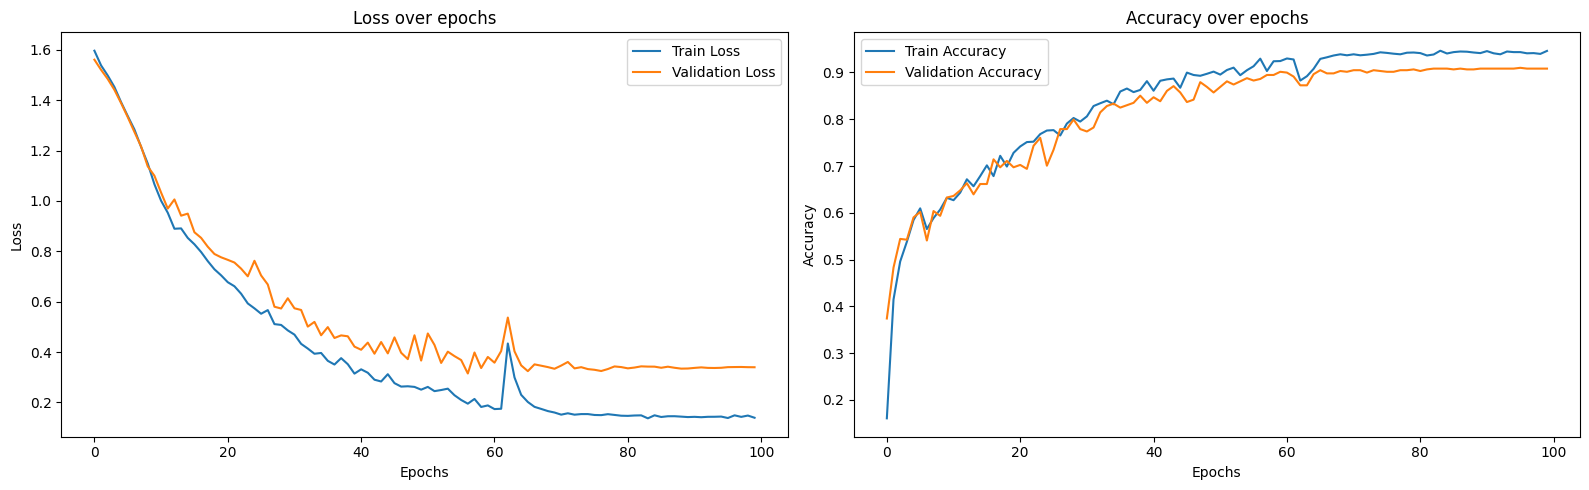

In [15]:
trainer.plot_training_history()

train bigger model

In [32]:
EMBED_DIM = 64
HIDDEN_DIM = 128
DROPOUT_P = 0.2

wbb_model = SimpleRNNClassifier(vocab_size, EMBED_DIM, HIDDEN_DIM, num_classes, DROPOUT_P).to(device)

In [33]:
counts = torch.tensor([1630, 478, 154, 441, 236], dtype=torch.float)
class_weights = 1.0 / counts
class_weights = class_weights / class_weights.sum() * len(counts)  # Normalize to num_classes

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

In [34]:
optimizer = torch.optim.Adam(wbb_model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

trainer = Trainer(wbb_model, criterion, optimizer, scheduler=scheduler, device=device)

In [35]:
trainer.train(train_loader, val_loader, epochs=100)

Epoch 1/100: 100%|██████████| 10/10 [01:33<00:00,  9.39s/it]


Epoch 1/100 | Train Loss: 1.5808 | Train Acc: 0.3977 | Val Loss: 1.4988 | Val Acc: 0.5017 | LR: 0.001000


Epoch 2/100: 100%|██████████| 10/10 [01:19<00:00,  7.95s/it]


Epoch 2/100 | Train Loss: 1.4621 | Train Acc: 0.5304 | Val Loss: 1.4016 | Val Acc: 0.5527 | LR: 0.001000


Epoch 3/100: 100%|██████████| 10/10 [01:22<00:00,  8.26s/it]


Epoch 3/100 | Train Loss: 1.3516 | Train Acc: 0.5678 | Val Loss: 1.3132 | Val Acc: 0.5901 | LR: 0.001000


Epoch 4/100: 100%|██████████| 10/10 [01:25<00:00,  8.58s/it]


Epoch 4/100 | Train Loss: 1.2617 | Train Acc: 0.5997 | Val Loss: 1.2465 | Val Acc: 0.6071 | LR: 0.001000


Epoch 5/100: 100%|██████████| 10/10 [01:39<00:00,  9.96s/it]


Epoch 5/100 | Train Loss: 1.1744 | Train Acc: 0.6031 | Val Loss: 1.1360 | Val Acc: 0.6224 | LR: 0.001000


Epoch 6/100: 100%|██████████| 10/10 [01:27<00:00,  8.72s/it]


Epoch 6/100 | Train Loss: 1.0700 | Train Acc: 0.6261 | Val Loss: 1.0181 | Val Acc: 0.6650 | LR: 0.001000


Epoch 7/100: 100%|██████████| 10/10 [01:18<00:00,  7.88s/it]


Epoch 7/100 | Train Loss: 0.9601 | Train Acc: 0.6687 | Val Loss: 0.9662 | Val Acc: 0.6276 | LR: 0.001000


Epoch 8/100: 100%|██████████| 10/10 [01:17<00:00,  7.74s/it]


Epoch 8/100 | Train Loss: 0.8829 | Train Acc: 0.6738 | Val Loss: 0.8513 | Val Acc: 0.6990 | LR: 0.001000


Epoch 9/100: 100%|██████████| 10/10 [01:18<00:00,  7.85s/it]


Epoch 9/100 | Train Loss: 0.7868 | Train Acc: 0.7248 | Val Loss: 0.7708 | Val Acc: 0.7398 | LR: 0.001000


Epoch 10/100: 100%|██████████| 10/10 [01:21<00:00,  8.16s/it]


Epoch 10/100 | Train Loss: 0.7269 | Train Acc: 0.7342 | Val Loss: 0.7213 | Val Acc: 0.7806 | LR: 0.001000


Epoch 11/100: 100%|██████████| 10/10 [01:20<00:00,  8.05s/it]


Epoch 11/100 | Train Loss: 0.6876 | Train Acc: 0.7627 | Val Loss: 0.6766 | Val Acc: 0.7891 | LR: 0.001000


Epoch 12/100: 100%|██████████| 10/10 [01:20<00:00,  8.06s/it]


Epoch 12/100 | Train Loss: 0.6120 | Train Acc: 0.7946 | Val Loss: 0.6670 | Val Acc: 0.7619 | LR: 0.001000


Epoch 13/100: 100%|██████████| 10/10 [01:19<00:00,  7.97s/it]


Epoch 13/100 | Train Loss: 0.5566 | Train Acc: 0.7937 | Val Loss: 0.6559 | Val Acc: 0.8061 | LR: 0.001000


Epoch 14/100: 100%|██████████| 10/10 [01:20<00:00,  8.02s/it]


Epoch 14/100 | Train Loss: 0.5296 | Train Acc: 0.7860 | Val Loss: 0.5970 | Val Acc: 0.8146 | LR: 0.001000


Epoch 15/100: 100%|██████████| 10/10 [01:19<00:00,  7.93s/it]


Epoch 15/100 | Train Loss: 0.4760 | Train Acc: 0.8167 | Val Loss: 0.5330 | Val Acc: 0.8163 | LR: 0.001000


Epoch 16/100: 100%|██████████| 10/10 [01:21<00:00,  8.14s/it]


Epoch 16/100 | Train Loss: 0.4360 | Train Acc: 0.8277 | Val Loss: 0.5457 | Val Acc: 0.8214 | LR: 0.001000


Epoch 17/100: 100%|██████████| 10/10 [01:21<00:00,  8.20s/it]


Epoch 17/100 | Train Loss: 0.4023 | Train Acc: 0.8422 | Val Loss: 0.5471 | Val Acc: 0.8299 | LR: 0.001000


Epoch 18/100: 100%|██████████| 10/10 [01:20<00:00,  8.06s/it]


Epoch 18/100 | Train Loss: 0.3734 | Train Acc: 0.8601 | Val Loss: 0.5165 | Val Acc: 0.8265 | LR: 0.001000


Epoch 19/100: 100%|██████████| 10/10 [01:24<00:00,  8.49s/it]


Epoch 19/100 | Train Loss: 0.3720 | Train Acc: 0.8452 | Val Loss: 0.4991 | Val Acc: 0.8690 | LR: 0.001000


Epoch 20/100: 100%|██████████| 10/10 [01:19<00:00,  7.97s/it]


Epoch 20/100 | Train Loss: 0.3308 | Train Acc: 0.8698 | Val Loss: 0.5389 | Val Acc: 0.8248 | LR: 0.001000


Epoch 21/100: 100%|██████████| 10/10 [01:22<00:00,  8.21s/it]


Epoch 21/100 | Train Loss: 0.3104 | Train Acc: 0.8643 | Val Loss: 0.4326 | Val Acc: 0.8435 | LR: 0.001000


Epoch 22/100: 100%|██████████| 10/10 [01:20<00:00,  8.01s/it]


Epoch 22/100 | Train Loss: 0.2796 | Train Acc: 0.8890 | Val Loss: 0.4098 | Val Acc: 0.8827 | LR: 0.001000


Epoch 23/100: 100%|██████████| 10/10 [01:26<00:00,  8.62s/it]


Epoch 23/100 | Train Loss: 0.2539 | Train Acc: 0.9000 | Val Loss: 0.5036 | Val Acc: 0.8656 | LR: 0.001000


Epoch 24/100: 100%|██████████| 10/10 [01:26<00:00,  8.70s/it]


Epoch 24/100 | Train Loss: 0.2432 | Train Acc: 0.9017 | Val Loss: 0.4719 | Val Acc: 0.8827 | LR: 0.001000


Epoch 25/100: 100%|██████████| 10/10 [01:23<00:00,  8.39s/it]


Epoch 25/100 | Train Loss: 0.2387 | Train Acc: 0.8979 | Val Loss: 0.4029 | Val Acc: 0.8861 | LR: 0.001000


Epoch 26/100: 100%|██████████| 10/10 [01:21<00:00,  8.18s/it]


Epoch 26/100 | Train Loss: 0.2228 | Train Acc: 0.9103 | Val Loss: 0.5359 | Val Acc: 0.8827 | LR: 0.001000


Epoch 27/100: 100%|██████████| 10/10 [01:23<00:00,  8.36s/it]


Epoch 27/100 | Train Loss: 0.2792 | Train Acc: 0.8945 | Val Loss: 0.4974 | Val Acc: 0.8793 | LR: 0.001000


Epoch 28/100: 100%|██████████| 10/10 [01:24<00:00,  8.43s/it]


Epoch 28/100 | Train Loss: 0.2675 | Train Acc: 0.9009 | Val Loss: 0.4566 | Val Acc: 0.8673 | LR: 0.001000


Epoch 29/100: 100%|██████████| 10/10 [01:21<00:00,  8.18s/it]


Epoch 29/100 | Train Loss: 0.2903 | Train Acc: 0.8898 | Val Loss: 0.4129 | Val Acc: 0.8776 | LR: 0.001000


Epoch 30/100: 100%|██████████| 10/10 [01:21<00:00,  8.12s/it]


Epoch 30/100 | Train Loss: 0.2296 | Train Acc: 0.9068 | Val Loss: 0.4337 | Val Acc: 0.8827 | LR: 0.001000


Epoch 31/100: 100%|██████████| 10/10 [01:20<00:00,  8.02s/it]


Epoch 31/100 | Train Loss: 0.2015 | Train Acc: 0.9294 | Val Loss: 0.3817 | Val Acc: 0.8827 | LR: 0.001000


Epoch 32/100: 100%|██████████| 10/10 [01:18<00:00,  7.83s/it]


Epoch 32/100 | Train Loss: 0.1897 | Train Acc: 0.9268 | Val Loss: 0.4539 | Val Acc: 0.8912 | LR: 0.001000


Epoch 33/100: 100%|██████████| 10/10 [01:22<00:00,  8.23s/it]


Epoch 33/100 | Train Loss: 0.2097 | Train Acc: 0.9298 | Val Loss: 0.3954 | Val Acc: 0.8861 | LR: 0.001000


Epoch 34/100: 100%|██████████| 10/10 [01:20<00:00,  8.06s/it]


Epoch 34/100 | Train Loss: 0.1873 | Train Acc: 0.9281 | Val Loss: 0.3912 | Val Acc: 0.8980 | LR: 0.001000


Epoch 35/100: 100%|██████████| 10/10 [01:25<00:00,  8.52s/it]


Epoch 35/100 | Train Loss: 0.1682 | Train Acc: 0.9302 | Val Loss: 0.4105 | Val Acc: 0.8895 | LR: 0.001000


Epoch 36/100: 100%|██████████| 10/10 [01:21<00:00,  8.20s/it]


Epoch 36/100 | Train Loss: 0.1368 | Train Acc: 0.9456 | Val Loss: 0.3819 | Val Acc: 0.9014 | LR: 0.001000


Epoch 37/100: 100%|██████████| 10/10 [01:21<00:00,  8.10s/it]


Epoch 37/100 | Train Loss: 0.1346 | Train Acc: 0.9511 | Val Loss: 0.3815 | Val Acc: 0.8946 | LR: 0.001000


Epoch 38/100: 100%|██████████| 10/10 [01:21<00:00,  8.11s/it]


Epoch 38/100 | Train Loss: 0.1693 | Train Acc: 0.9192 | Val Loss: 0.4424 | Val Acc: 0.8946 | LR: 0.001000


Epoch 39/100: 100%|██████████| 10/10 [01:25<00:00,  8.54s/it]


Epoch 39/100 | Train Loss: 0.1970 | Train Acc: 0.9141 | Val Loss: 0.4872 | Val Acc: 0.8827 | LR: 0.001000


Epoch 40/100: 100%|██████████| 10/10 [01:25<00:00,  8.54s/it]


Epoch 40/100 | Train Loss: 0.2412 | Train Acc: 0.9358 | Val Loss: 0.4160 | Val Acc: 0.8707 | LR: 0.001000


Epoch 41/100: 100%|██████████| 10/10 [01:24<00:00,  8.46s/it]


Epoch 41/100 | Train Loss: 0.1845 | Train Acc: 0.9281 | Val Loss: 0.5401 | Val Acc: 0.8929 | LR: 0.001000


Epoch 42/100: 100%|██████████| 10/10 [01:21<00:00,  8.14s/it]


Epoch 42/100 | Train Loss: 0.1292 | Train Acc: 0.9498 | Val Loss: 0.4958 | Val Acc: 0.9014 | LR: 0.001000


Epoch 43/100: 100%|██████████| 10/10 [01:24<00:00,  8.45s/it]


Epoch 43/100 | Train Loss: 0.1209 | Train Acc: 0.9532 | Val Loss: 0.5103 | Val Acc: 0.8759 | LR: 0.000500


Epoch 44/100: 100%|██████████| 10/10 [01:21<00:00,  8.19s/it]


Epoch 44/100 | Train Loss: 0.1518 | Train Acc: 0.9281 | Val Loss: 0.4435 | Val Acc: 0.8912 | LR: 0.000500


Epoch 45/100: 100%|██████████| 10/10 [01:22<00:00,  8.30s/it]


Epoch 45/100 | Train Loss: 0.1167 | Train Acc: 0.9549 | Val Loss: 0.4396 | Val Acc: 0.8997 | LR: 0.000500


Epoch 46/100: 100%|██████████| 10/10 [01:21<00:00,  8.10s/it]


Epoch 46/100 | Train Loss: 0.1123 | Train Acc: 0.9519 | Val Loss: 0.4743 | Val Acc: 0.8946 | LR: 0.000500


Epoch 47/100: 100%|██████████| 10/10 [01:23<00:00,  8.32s/it]


Epoch 47/100 | Train Loss: 0.1030 | Train Acc: 0.9617 | Val Loss: 0.3913 | Val Acc: 0.8997 | LR: 0.000500


Epoch 48/100: 100%|██████████| 10/10 [01:16<00:00,  7.60s/it]


Epoch 48/100 | Train Loss: 0.1195 | Train Acc: 0.9324 | Val Loss: 0.3764 | Val Acc: 0.9014 | LR: 0.000500


Epoch 49/100: 100%|██████████| 10/10 [01:14<00:00,  7.43s/it]


Epoch 49/100 | Train Loss: 0.1021 | Train Acc: 0.9587 | Val Loss: 0.4157 | Val Acc: 0.9048 | LR: 0.000500


Epoch 50/100: 100%|██████████| 10/10 [01:15<00:00,  7.52s/it]


Epoch 50/100 | Train Loss: 0.0936 | Train Acc: 0.9600 | Val Loss: 0.3988 | Val Acc: 0.9065 | LR: 0.000500


Epoch 51/100: 100%|██████████| 10/10 [01:17<00:00,  7.77s/it]


Epoch 51/100 | Train Loss: 0.0855 | Train Acc: 0.9685 | Val Loss: 0.3958 | Val Acc: 0.9133 | LR: 0.000500


Epoch 52/100: 100%|██████████| 10/10 [01:14<00:00,  7.43s/it]


Epoch 52/100 | Train Loss: 0.0801 | Train Acc: 0.9681 | Val Loss: 0.3932 | Val Acc: 0.9048 | LR: 0.000500


Epoch 53/100: 100%|██████████| 10/10 [01:14<00:00,  7.48s/it]


Epoch 53/100 | Train Loss: 0.0791 | Train Acc: 0.9694 | Val Loss: 0.4262 | Val Acc: 0.9099 | LR: 0.000500


Epoch 54/100: 100%|██████████| 10/10 [01:17<00:00,  7.76s/it]


Epoch 54/100 | Train Loss: 0.0800 | Train Acc: 0.9668 | Val Loss: 0.4208 | Val Acc: 0.9048 | LR: 0.000250


Epoch 55/100: 100%|██████████| 10/10 [01:13<00:00,  7.31s/it]


Epoch 55/100 | Train Loss: 0.0872 | Train Acc: 0.9715 | Val Loss: 0.4225 | Val Acc: 0.9048 | LR: 0.000250


Epoch 56/100: 100%|██████████| 10/10 [01:18<00:00,  7.80s/it]


Epoch 56/100 | Train Loss: 0.0699 | Train Acc: 0.9724 | Val Loss: 0.4119 | Val Acc: 0.9065 | LR: 0.000250


Epoch 57/100: 100%|██████████| 10/10 [01:11<00:00,  7.15s/it]


Epoch 57/100 | Train Loss: 0.0639 | Train Acc: 0.9741 | Val Loss: 0.4169 | Val Acc: 0.9150 | LR: 0.000250


Epoch 58/100: 100%|██████████| 10/10 [01:15<00:00,  7.54s/it]


Epoch 58/100 | Train Loss: 0.0727 | Train Acc: 0.9702 | Val Loss: 0.4266 | Val Acc: 0.9082 | LR: 0.000250


Epoch 59/100: 100%|██████████| 10/10 [01:16<00:00,  7.63s/it]


Epoch 59/100 | Train Loss: 0.0722 | Train Acc: 0.9724 | Val Loss: 0.4228 | Val Acc: 0.9099 | LR: 0.000250


Epoch 60/100: 100%|██████████| 10/10 [01:16<00:00,  7.63s/it]


Epoch 60/100 | Train Loss: 0.0638 | Train Acc: 0.9736 | Val Loss: 0.4240 | Val Acc: 0.9065 | LR: 0.000125


Epoch 61/100: 100%|██████████| 10/10 [01:17<00:00,  7.79s/it]


Epoch 61/100 | Train Loss: 0.0638 | Train Acc: 0.9732 | Val Loss: 0.4281 | Val Acc: 0.9099 | LR: 0.000125


Epoch 62/100: 100%|██████████| 10/10 [01:15<00:00,  7.54s/it]


Epoch 62/100 | Train Loss: 0.0608 | Train Acc: 0.9749 | Val Loss: 0.4364 | Val Acc: 0.9150 | LR: 0.000125


Epoch 63/100: 100%|██████████| 10/10 [01:14<00:00,  7.50s/it]


Epoch 63/100 | Train Loss: 0.0632 | Train Acc: 0.9758 | Val Loss: 0.4294 | Val Acc: 0.9099 | LR: 0.000125


Epoch 64/100: 100%|██████████| 10/10 [01:16<00:00,  7.64s/it]


Epoch 64/100 | Train Loss: 0.0575 | Train Acc: 0.9775 | Val Loss: 0.4255 | Val Acc: 0.9099 | LR: 0.000125


Epoch 65/100: 100%|██████████| 10/10 [01:17<00:00,  7.75s/it]


Epoch 65/100 | Train Loss: 0.0614 | Train Acc: 0.9753 | Val Loss: 0.4327 | Val Acc: 0.9133 | LR: 0.000125


Epoch 66/100: 100%|██████████| 10/10 [01:17<00:00,  7.73s/it]


Epoch 66/100 | Train Loss: 0.0581 | Train Acc: 0.9775 | Val Loss: 0.4449 | Val Acc: 0.9150 | LR: 0.000063


Epoch 67/100: 100%|██████████| 10/10 [01:14<00:00,  7.41s/it]


Epoch 67/100 | Train Loss: 0.0658 | Train Acc: 0.9753 | Val Loss: 0.4450 | Val Acc: 0.9133 | LR: 0.000063


Epoch 68/100: 100%|██████████| 10/10 [01:16<00:00,  7.64s/it]


Epoch 68/100 | Train Loss: 0.0594 | Train Acc: 0.9800 | Val Loss: 0.4506 | Val Acc: 0.9082 | LR: 0.000063


Epoch 69/100: 100%|██████████| 10/10 [01:21<00:00,  8.19s/it]


Epoch 69/100 | Train Loss: 0.0604 | Train Acc: 0.9745 | Val Loss: 0.4631 | Val Acc: 0.9065 | LR: 0.000063


Epoch 70/100: 100%|██████████| 10/10 [01:17<00:00,  7.79s/it]


Epoch 70/100 | Train Loss: 0.0592 | Train Acc: 0.9762 | Val Loss: 0.4593 | Val Acc: 0.9082 | LR: 0.000063


Epoch 71/100: 100%|██████████| 10/10 [01:18<00:00,  7.82s/it]


Epoch 71/100 | Train Loss: 0.0588 | Train Acc: 0.9775 | Val Loss: 0.4559 | Val Acc: 0.9065 | LR: 0.000063


Epoch 72/100: 100%|██████████| 10/10 [01:14<00:00,  7.47s/it]


Epoch 72/100 | Train Loss: 0.0567 | Train Acc: 0.9792 | Val Loss: 0.4471 | Val Acc: 0.9150 | LR: 0.000031


Epoch 73/100: 100%|██████████| 10/10 [01:18<00:00,  7.84s/it]


Epoch 73/100 | Train Loss: 0.0596 | Train Acc: 0.9766 | Val Loss: 0.4467 | Val Acc: 0.9133 | LR: 0.000031


Epoch 74/100: 100%|██████████| 10/10 [01:13<00:00,  7.33s/it]


Epoch 74/100 | Train Loss: 0.0592 | Train Acc: 0.9809 | Val Loss: 0.4442 | Val Acc: 0.9150 | LR: 0.000031


Epoch 75/100: 100%|██████████| 10/10 [01:19<00:00,  7.99s/it]


Epoch 75/100 | Train Loss: 0.0563 | Train Acc: 0.9770 | Val Loss: 0.4438 | Val Acc: 0.9133 | LR: 0.000031


Epoch 76/100: 100%|██████████| 10/10 [01:19<00:00,  7.91s/it]


Epoch 76/100 | Train Loss: 0.0640 | Train Acc: 0.9775 | Val Loss: 0.4420 | Val Acc: 0.9133 | LR: 0.000031


Epoch 77/100: 100%|██████████| 10/10 [01:19<00:00,  7.91s/it]


Epoch 77/100 | Train Loss: 0.0538 | Train Acc: 0.9787 | Val Loss: 0.4427 | Val Acc: 0.9133 | LR: 0.000031


Epoch 78/100: 100%|██████████| 10/10 [01:15<00:00,  7.57s/it]


Epoch 78/100 | Train Loss: 0.0570 | Train Acc: 0.9770 | Val Loss: 0.4372 | Val Acc: 0.9133 | LR: 0.000016


Epoch 79/100: 100%|██████████| 10/10 [01:18<00:00,  7.83s/it]


Epoch 79/100 | Train Loss: 0.0603 | Train Acc: 0.9766 | Val Loss: 0.4372 | Val Acc: 0.9133 | LR: 0.000016


Epoch 80/100: 100%|██████████| 10/10 [01:21<00:00,  8.12s/it]


Epoch 80/100 | Train Loss: 0.0625 | Train Acc: 0.9766 | Val Loss: 0.4375 | Val Acc: 0.9116 | LR: 0.000016


Epoch 81/100: 100%|██████████| 10/10 [01:14<00:00,  7.49s/it]


Epoch 81/100 | Train Loss: 0.0602 | Train Acc: 0.9762 | Val Loss: 0.4385 | Val Acc: 0.9116 | LR: 0.000016


Epoch 82/100: 100%|██████████| 10/10 [01:19<00:00,  7.96s/it]


Epoch 82/100 | Train Loss: 0.0572 | Train Acc: 0.9775 | Val Loss: 0.4398 | Val Acc: 0.9116 | LR: 0.000016


Epoch 83/100: 100%|██████████| 10/10 [01:21<00:00,  8.16s/it]


Epoch 83/100 | Train Loss: 0.0634 | Train Acc: 0.9753 | Val Loss: 0.4407 | Val Acc: 0.9116 | LR: 0.000016


Epoch 84/100: 100%|██████████| 10/10 [01:18<00:00,  7.84s/it]


Epoch 84/100 | Train Loss: 0.0578 | Train Acc: 0.9783 | Val Loss: 0.4406 | Val Acc: 0.9133 | LR: 0.000008


Epoch 85/100: 100%|██████████| 10/10 [01:17<00:00,  7.73s/it]


Epoch 85/100 | Train Loss: 0.0552 | Train Acc: 0.9796 | Val Loss: 0.4411 | Val Acc: 0.9133 | LR: 0.000008


Epoch 86/100: 100%|██████████| 10/10 [01:15<00:00,  7.55s/it]


Epoch 86/100 | Train Loss: 0.0593 | Train Acc: 0.9749 | Val Loss: 0.4414 | Val Acc: 0.9133 | LR: 0.000008


Epoch 87/100: 100%|██████████| 10/10 [01:18<00:00,  7.81s/it]


Epoch 87/100 | Train Loss: 0.0591 | Train Acc: 0.9770 | Val Loss: 0.4407 | Val Acc: 0.9133 | LR: 0.000008


Epoch 88/100: 100%|██████████| 10/10 [01:19<00:00,  7.92s/it]


Epoch 88/100 | Train Loss: 0.0548 | Train Acc: 0.9783 | Val Loss: 0.4406 | Val Acc: 0.9133 | LR: 0.000008


Epoch 89/100: 100%|██████████| 10/10 [01:16<00:00,  7.65s/it]


Epoch 89/100 | Train Loss: 0.0581 | Train Acc: 0.9762 | Val Loss: 0.4409 | Val Acc: 0.9133 | LR: 0.000008


Epoch 90/100: 100%|██████████| 10/10 [01:18<00:00,  7.81s/it]


Epoch 90/100 | Train Loss: 0.0555 | Train Acc: 0.9787 | Val Loss: 0.4409 | Val Acc: 0.9133 | LR: 0.000004


Epoch 91/100: 100%|██████████| 10/10 [01:16<00:00,  7.69s/it]


Epoch 91/100 | Train Loss: 0.0596 | Train Acc: 0.9779 | Val Loss: 0.4405 | Val Acc: 0.9133 | LR: 0.000004


Epoch 92/100: 100%|██████████| 10/10 [01:19<00:00,  7.93s/it]


Epoch 92/100 | Train Loss: 0.0630 | Train Acc: 0.9758 | Val Loss: 0.4403 | Val Acc: 0.9133 | LR: 0.000004


Epoch 93/100: 100%|██████████| 10/10 [01:15<00:00,  7.55s/it]


Epoch 93/100 | Train Loss: 0.0551 | Train Acc: 0.9792 | Val Loss: 0.4405 | Val Acc: 0.9133 | LR: 0.000004


Epoch 94/100: 100%|██████████| 10/10 [01:16<00:00,  7.64s/it]


Epoch 94/100 | Train Loss: 0.0608 | Train Acc: 0.9749 | Val Loss: 0.4406 | Val Acc: 0.9133 | LR: 0.000004


Epoch 95/100: 100%|██████████| 10/10 [01:20<00:00,  8.03s/it]


Epoch 95/100 | Train Loss: 0.0576 | Train Acc: 0.9758 | Val Loss: 0.4407 | Val Acc: 0.9133 | LR: 0.000004


Epoch 96/100: 100%|██████████| 10/10 [01:14<00:00,  7.41s/it]


Epoch 96/100 | Train Loss: 0.0590 | Train Acc: 0.9758 | Val Loss: 0.4411 | Val Acc: 0.9116 | LR: 0.000002


Epoch 97/100: 100%|██████████| 10/10 [01:20<00:00,  8.04s/it]


Epoch 97/100 | Train Loss: 0.0634 | Train Acc: 0.9766 | Val Loss: 0.4414 | Val Acc: 0.9099 | LR: 0.000002


Epoch 98/100: 100%|██████████| 10/10 [01:19<00:00,  7.97s/it]


Epoch 98/100 | Train Loss: 0.0546 | Train Acc: 0.9787 | Val Loss: 0.4416 | Val Acc: 0.9099 | LR: 0.000002


Epoch 99/100: 100%|██████████| 10/10 [01:16<00:00,  7.66s/it]


Epoch 99/100 | Train Loss: 0.0600 | Train Acc: 0.9762 | Val Loss: 0.4418 | Val Acc: 0.9099 | LR: 0.000002


Epoch 100/100: 100%|██████████| 10/10 [01:22<00:00,  8.29s/it]


Epoch 100/100 | Train Loss: 0.0629 | Train Acc: 0.9753 | Val Loss: 0.4418 | Val Acc: 0.9099 | LR: 0.000002


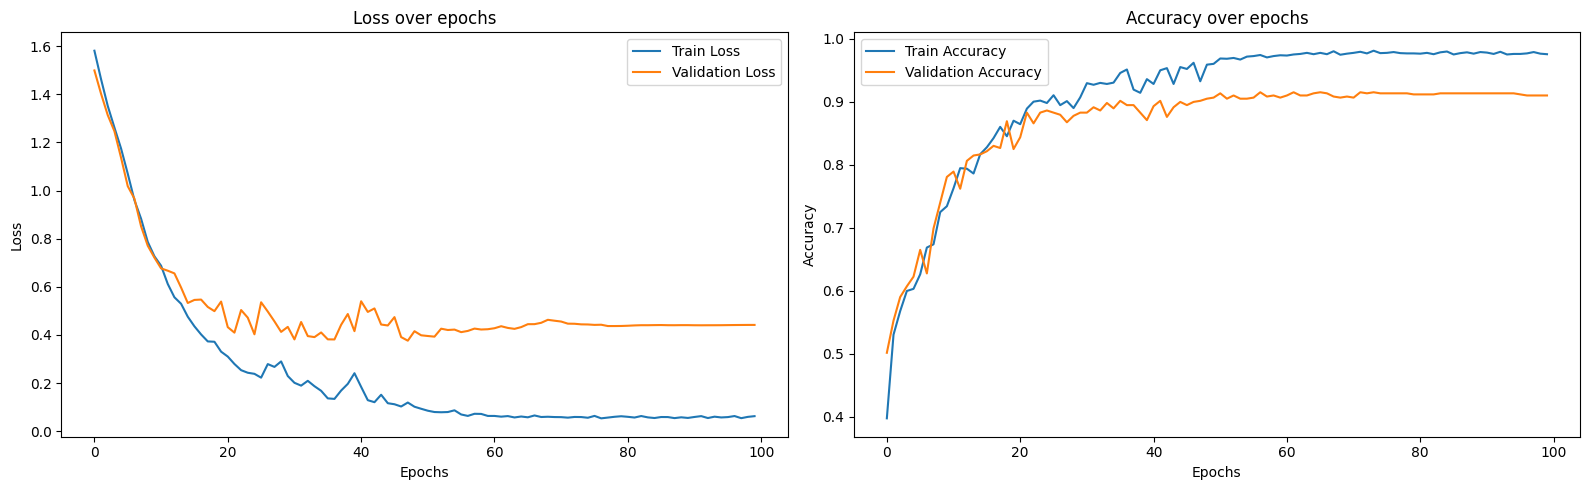

In [36]:
trainer.plot_training_history()

In [37]:
trainer.save_model("./wbb_model.pt")

Model saved to ./wbb_model.pt


### With sampling, with dropout

In [16]:
EMBED_DIM = 32
HIDDEN_DIM = 64
DROPOUT_P = 0.2

s_model = SimpleRNNClassifier(vocab_size, EMBED_DIM, HIDDEN_DIM, num_classes, DROPOUT_P).to(device)

In [17]:
criterion = nn.CrossEntropyLoss()

In [18]:
optimizer = torch.optim.Adam(s_model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

trainer = Trainer(s_model, criterion, optimizer, scheduler=scheduler, device=device)

Perfrom training on the default trianing set with sampling

In [19]:
trainer.train(sampled_train_loader, val_loader, epochs=100)

Epoch 1/100: 100%|██████████| 10/10 [00:52<00:00,  5.21s/it]


Epoch 1/100 | Train Loss: 1.5972 | Train Acc: 0.2578 | Val Loss: 1.5534 | Val Acc: 0.3895 | LR: 0.001000


Epoch 2/100: 100%|██████████| 10/10 [00:47<00:00,  4.70s/it]


Epoch 2/100 | Train Loss: 1.5457 | Train Acc: 0.3543 | Val Loss: 1.4934 | Val Acc: 0.4269 | LR: 0.001000


Epoch 3/100: 100%|██████████| 10/10 [00:45<00:00,  4.56s/it]


Epoch 3/100 | Train Loss: 1.4918 | Train Acc: 0.4071 | Val Loss: 1.4261 | Val Acc: 0.4898 | LR: 0.001000


Epoch 4/100: 100%|██████████| 10/10 [00:46<00:00,  4.62s/it]


Epoch 4/100 | Train Loss: 1.4255 | Train Acc: 0.4432 | Val Loss: 1.3368 | Val Acc: 0.5085 | LR: 0.001000


Epoch 5/100: 100%|██████████| 10/10 [00:45<00:00,  4.52s/it]


Epoch 5/100 | Train Loss: 1.3847 | Train Acc: 0.4317 | Val Loss: 1.2635 | Val Acc: 0.5255 | LR: 0.001000


Epoch 6/100: 100%|██████████| 10/10 [00:48<00:00,  4.86s/it]


Epoch 6/100 | Train Loss: 1.3091 | Train Acc: 0.4934 | Val Loss: 1.2707 | Val Acc: 0.5442 | LR: 0.001000


Epoch 7/100: 100%|██████████| 10/10 [00:43<00:00,  4.36s/it]


Epoch 7/100 | Train Loss: 1.2838 | Train Acc: 0.5283 | Val Loss: 1.2224 | Val Acc: 0.5714 | LR: 0.001000


Epoch 8/100: 100%|██████████| 10/10 [00:44<00:00,  4.49s/it]


Epoch 8/100 | Train Loss: 1.2147 | Train Acc: 0.5436 | Val Loss: 1.1281 | Val Acc: 0.6054 | LR: 0.001000


Epoch 9/100: 100%|██████████| 10/10 [00:52<00:00,  5.20s/it]


Epoch 9/100 | Train Loss: 1.1253 | Train Acc: 0.6019 | Val Loss: 1.0956 | Val Acc: 0.6139 | LR: 0.001000


Epoch 10/100: 100%|██████████| 10/10 [00:50<00:00,  5.10s/it]


Epoch 10/100 | Train Loss: 1.0273 | Train Acc: 0.6210 | Val Loss: 1.0022 | Val Acc: 0.6344 | LR: 0.001000


Epoch 11/100: 100%|██████████| 10/10 [00:45<00:00,  4.57s/it]


Epoch 11/100 | Train Loss: 0.9612 | Train Acc: 0.6308 | Val Loss: 1.0556 | Val Acc: 0.6088 | LR: 0.001000


Epoch 12/100: 100%|██████████| 10/10 [00:50<00:00,  5.01s/it]


Epoch 12/100 | Train Loss: 0.9116 | Train Acc: 0.6678 | Val Loss: 0.9129 | Val Acc: 0.6514 | LR: 0.001000


Epoch 13/100: 100%|██████████| 10/10 [00:46<00:00,  4.69s/it]


Epoch 13/100 | Train Loss: 0.7880 | Train Acc: 0.7146 | Val Loss: 0.8737 | Val Acc: 0.6820 | LR: 0.001000


Epoch 14/100: 100%|██████████| 10/10 [00:46<00:00,  4.62s/it]


Epoch 14/100 | Train Loss: 0.7767 | Train Acc: 0.7252 | Val Loss: 0.8672 | Val Acc: 0.7007 | LR: 0.001000


Epoch 15/100: 100%|██████████| 10/10 [00:41<00:00,  4.16s/it]


Epoch 15/100 | Train Loss: 0.7408 | Train Acc: 0.7380 | Val Loss: 0.7968 | Val Acc: 0.7143 | LR: 0.001000


Epoch 16/100: 100%|██████████| 10/10 [00:48<00:00,  4.88s/it]


Epoch 16/100 | Train Loss: 0.8282 | Train Acc: 0.6963 | Val Loss: 1.0138 | Val Acc: 0.6446 | LR: 0.001000


Epoch 17/100: 100%|██████████| 10/10 [00:48<00:00,  4.89s/it]


Epoch 17/100 | Train Loss: 0.7487 | Train Acc: 0.7291 | Val Loss: 0.7398 | Val Acc: 0.7483 | LR: 0.001000


Epoch 18/100: 100%|██████████| 10/10 [00:48<00:00,  4.83s/it]


Epoch 18/100 | Train Loss: 0.6882 | Train Acc: 0.7635 | Val Loss: 0.7496 | Val Acc: 0.7449 | LR: 0.001000


Epoch 19/100: 100%|██████████| 10/10 [00:48<00:00,  4.83s/it]


Epoch 19/100 | Train Loss: 0.6680 | Train Acc: 0.7524 | Val Loss: 0.7685 | Val Acc: 0.7330 | LR: 0.001000


Epoch 20/100: 100%|██████████| 10/10 [00:45<00:00,  4.57s/it]


Epoch 20/100 | Train Loss: 0.6106 | Train Acc: 0.7920 | Val Loss: 0.6563 | Val Acc: 0.7670 | LR: 0.001000


Epoch 21/100: 100%|██████████| 10/10 [00:42<00:00,  4.21s/it]


Epoch 21/100 | Train Loss: 0.6038 | Train Acc: 0.7848 | Val Loss: 0.7252 | Val Acc: 0.7551 | LR: 0.001000


Epoch 22/100: 100%|██████████| 10/10 [00:50<00:00,  5.04s/it]


Epoch 22/100 | Train Loss: 0.5820 | Train Acc: 0.7992 | Val Loss: 0.6102 | Val Acc: 0.7840 | LR: 0.001000


Epoch 23/100: 100%|██████████| 10/10 [00:46<00:00,  4.62s/it]


Epoch 23/100 | Train Loss: 0.5640 | Train Acc: 0.8005 | Val Loss: 0.6144 | Val Acc: 0.7789 | LR: 0.001000


Epoch 24/100: 100%|██████████| 10/10 [00:52<00:00,  5.20s/it]


Epoch 24/100 | Train Loss: 0.5204 | Train Acc: 0.8128 | Val Loss: 0.6185 | Val Acc: 0.7891 | LR: 0.001000


Epoch 25/100: 100%|██████████| 10/10 [00:44<00:00,  4.41s/it]


Epoch 25/100 | Train Loss: 0.5592 | Train Acc: 0.8018 | Val Loss: 0.5802 | Val Acc: 0.7993 | LR: 0.001000


Epoch 26/100: 100%|██████████| 10/10 [00:47<00:00,  4.73s/it]


Epoch 26/100 | Train Loss: 0.5194 | Train Acc: 0.8137 | Val Loss: 0.5852 | Val Acc: 0.7959 | LR: 0.001000


Epoch 27/100: 100%|██████████| 10/10 [00:49<00:00,  4.96s/it]


Epoch 27/100 | Train Loss: 0.4951 | Train Acc: 0.8294 | Val Loss: 0.5607 | Val Acc: 0.8078 | LR: 0.001000


Epoch 28/100: 100%|██████████| 10/10 [00:43<00:00,  4.34s/it]


Epoch 28/100 | Train Loss: 0.4920 | Train Acc: 0.8273 | Val Loss: 0.5062 | Val Acc: 0.8265 | LR: 0.001000


Epoch 29/100: 100%|██████████| 10/10 [00:52<00:00,  5.22s/it]


Epoch 29/100 | Train Loss: 0.4317 | Train Acc: 0.8443 | Val Loss: 0.5220 | Val Acc: 0.8129 | LR: 0.001000


Epoch 30/100: 100%|██████████| 10/10 [00:50<00:00,  5.09s/it]


Epoch 30/100 | Train Loss: 0.4046 | Train Acc: 0.8605 | Val Loss: 0.4626 | Val Acc: 0.8435 | LR: 0.001000


Epoch 31/100: 100%|██████████| 10/10 [00:52<00:00,  5.28s/it]


Epoch 31/100 | Train Loss: 0.4070 | Train Acc: 0.8656 | Val Loss: 0.4871 | Val Acc: 0.8333 | LR: 0.001000


Epoch 32/100: 100%|██████████| 10/10 [00:55<00:00,  5.59s/it]


Epoch 32/100 | Train Loss: 0.3994 | Train Acc: 0.8596 | Val Loss: 0.4715 | Val Acc: 0.8231 | LR: 0.001000


Epoch 33/100: 100%|██████████| 10/10 [00:51<00:00,  5.12s/it]


Epoch 33/100 | Train Loss: 0.3895 | Train Acc: 0.8737 | Val Loss: 0.4770 | Val Acc: 0.8316 | LR: 0.001000


Epoch 34/100: 100%|██████████| 10/10 [00:41<00:00,  4.18s/it]


Epoch 34/100 | Train Loss: 0.3680 | Train Acc: 0.8715 | Val Loss: 0.4179 | Val Acc: 0.8571 | LR: 0.001000


Epoch 35/100: 100%|██████████| 10/10 [00:44<00:00,  4.45s/it]


Epoch 35/100 | Train Loss: 0.3505 | Train Acc: 0.8775 | Val Loss: 0.4817 | Val Acc: 0.8265 | LR: 0.001000


Epoch 36/100: 100%|██████████| 10/10 [00:42<00:00,  4.20s/it]


Epoch 36/100 | Train Loss: 0.3566 | Train Acc: 0.8737 | Val Loss: 0.4486 | Val Acc: 0.8452 | LR: 0.001000


Epoch 37/100: 100%|██████████| 10/10 [00:55<00:00,  5.51s/it]


Epoch 37/100 | Train Loss: 0.3344 | Train Acc: 0.8860 | Val Loss: 0.4859 | Val Acc: 0.8469 | LR: 0.001000


Epoch 38/100: 100%|██████████| 10/10 [00:52<00:00,  5.21s/it]


Epoch 38/100 | Train Loss: 0.3499 | Train Acc: 0.8779 | Val Loss: 0.4139 | Val Acc: 0.8639 | LR: 0.001000


Epoch 39/100: 100%|██████████| 10/10 [00:50<00:00,  5.01s/it]


Epoch 39/100 | Train Loss: 0.3185 | Train Acc: 0.9005 | Val Loss: 0.5051 | Val Acc: 0.8367 | LR: 0.001000


Epoch 40/100: 100%|██████████| 10/10 [00:47<00:00,  4.78s/it]


Epoch 40/100 | Train Loss: 0.3105 | Train Acc: 0.8975 | Val Loss: 0.4608 | Val Acc: 0.8418 | LR: 0.001000


Epoch 41/100: 100%|██████████| 10/10 [00:44<00:00,  4.49s/it]


Epoch 41/100 | Train Loss: 0.3121 | Train Acc: 0.8911 | Val Loss: 0.4559 | Val Acc: 0.8537 | LR: 0.001000


Epoch 42/100: 100%|██████████| 10/10 [08:27<00:00, 50.72s/it]


Epoch 42/100 | Train Loss: 0.3166 | Train Acc: 0.9005 | Val Loss: 0.4828 | Val Acc: 0.8469 | LR: 0.001000


Epoch 43/100: 100%|██████████| 10/10 [00:48<00:00,  4.89s/it]


Epoch 43/100 | Train Loss: 0.2792 | Train Acc: 0.9073 | Val Loss: 0.3914 | Val Acc: 0.8707 | LR: 0.001000


Epoch 44/100: 100%|██████████| 10/10 [00:52<00:00,  5.25s/it]


Epoch 44/100 | Train Loss: 0.2751 | Train Acc: 0.9154 | Val Loss: 0.4037 | Val Acc: 0.8707 | LR: 0.001000


Epoch 45/100: 100%|██████████| 10/10 [00:55<00:00,  5.53s/it]


Epoch 45/100 | Train Loss: 0.2524 | Train Acc: 0.9200 | Val Loss: 0.3780 | Val Acc: 0.8776 | LR: 0.001000


Epoch 46/100: 100%|██████████| 10/10 [00:59<00:00,  5.97s/it]


Epoch 46/100 | Train Loss: 0.2366 | Train Acc: 0.9285 | Val Loss: 0.3960 | Val Acc: 0.8810 | LR: 0.001000


Epoch 47/100: 100%|██████████| 10/10 [00:54<00:00,  5.48s/it]


Epoch 47/100 | Train Loss: 0.2508 | Train Acc: 0.9196 | Val Loss: 0.4048 | Val Acc: 0.8673 | LR: 0.001000


Epoch 48/100: 100%|██████████| 10/10 [00:52<00:00,  5.21s/it]


Epoch 48/100 | Train Loss: 0.2717 | Train Acc: 0.9081 | Val Loss: 0.3694 | Val Acc: 0.8844 | LR: 0.001000


Epoch 49/100: 100%|██████████| 10/10 [00:52<00:00,  5.21s/it]


Epoch 49/100 | Train Loss: 0.2615 | Train Acc: 0.9145 | Val Loss: 0.4745 | Val Acc: 0.8486 | LR: 0.001000


Epoch 50/100: 100%|██████████| 10/10 [00:48<00:00,  4.88s/it]


Epoch 50/100 | Train Loss: 0.2199 | Train Acc: 0.9273 | Val Loss: 0.4114 | Val Acc: 0.8622 | LR: 0.001000


Epoch 51/100: 100%|██████████| 10/10 [00:53<00:00,  5.35s/it]


Epoch 51/100 | Train Loss: 0.2280 | Train Acc: 0.9234 | Val Loss: 0.3743 | Val Acc: 0.8776 | LR: 0.001000


Epoch 52/100: 100%|██████████| 10/10 [00:52<00:00,  5.23s/it]


Epoch 52/100 | Train Loss: 0.2303 | Train Acc: 0.9239 | Val Loss: 0.4012 | Val Acc: 0.8793 | LR: 0.001000


Epoch 53/100: 100%|██████████| 10/10 [00:45<00:00,  4.54s/it]


Epoch 53/100 | Train Loss: 0.2693 | Train Acc: 0.9090 | Val Loss: 0.3708 | Val Acc: 0.8912 | LR: 0.001000


Epoch 54/100: 100%|██████████| 10/10 [00:50<00:00,  5.06s/it]


Epoch 54/100 | Train Loss: 0.2219 | Train Acc: 0.9268 | Val Loss: 0.3874 | Val Acc: 0.8673 | LR: 0.000500


Epoch 55/100: 100%|██████████| 10/10 [01:05<00:00,  6.52s/it]


Epoch 55/100 | Train Loss: 0.2295 | Train Acc: 0.9196 | Val Loss: 0.3809 | Val Acc: 0.8844 | LR: 0.000500


Epoch 56/100: 100%|██████████| 10/10 [00:58<00:00,  5.83s/it]


Epoch 56/100 | Train Loss: 0.2136 | Train Acc: 0.9311 | Val Loss: 0.3836 | Val Acc: 0.8793 | LR: 0.000500


Epoch 57/100: 100%|██████████| 10/10 [00:44<00:00,  4.48s/it]


Epoch 57/100 | Train Loss: 0.2128 | Train Acc: 0.9298 | Val Loss: 0.3772 | Val Acc: 0.8793 | LR: 0.000500


Epoch 58/100: 100%|██████████| 10/10 [00:59<00:00,  5.97s/it]


Epoch 58/100 | Train Loss: 0.2042 | Train Acc: 0.9387 | Val Loss: 0.4128 | Val Acc: 0.8776 | LR: 0.000500


Epoch 59/100: 100%|██████████| 10/10 [00:42<00:00,  4.26s/it]


Epoch 59/100 | Train Loss: 0.1984 | Train Acc: 0.9366 | Val Loss: 0.3841 | Val Acc: 0.8878 | LR: 0.000500


Epoch 60/100: 100%|██████████| 10/10 [00:57<00:00,  5.79s/it]


Epoch 60/100 | Train Loss: 0.1883 | Train Acc: 0.9426 | Val Loss: 0.3735 | Val Acc: 0.8827 | LR: 0.000250


Epoch 61/100: 100%|██████████| 10/10 [00:49<00:00,  4.94s/it]


Epoch 61/100 | Train Loss: 0.1881 | Train Acc: 0.9400 | Val Loss: 0.4115 | Val Acc: 0.8793 | LR: 0.000250


Epoch 62/100: 100%|██████████| 10/10 [00:53<00:00,  5.31s/it]


Epoch 62/100 | Train Loss: 0.1629 | Train Acc: 0.9494 | Val Loss: 0.3850 | Val Acc: 0.8844 | LR: 0.000250


Epoch 63/100: 100%|██████████| 10/10 [00:56<00:00,  5.63s/it]


Epoch 63/100 | Train Loss: 0.1743 | Train Acc: 0.9443 | Val Loss: 0.3736 | Val Acc: 0.8929 | LR: 0.000250


Epoch 64/100: 100%|██████████| 10/10 [00:53<00:00,  5.32s/it]


Epoch 64/100 | Train Loss: 0.1821 | Train Acc: 0.9396 | Val Loss: 0.3669 | Val Acc: 0.8912 | LR: 0.000250


Epoch 65/100: 100%|██████████| 10/10 [00:51<00:00,  5.19s/it]


Epoch 65/100 | Train Loss: 0.1744 | Train Acc: 0.9439 | Val Loss: 0.3692 | Val Acc: 0.8895 | LR: 0.000250


Epoch 66/100: 100%|██████████| 10/10 [00:52<00:00,  5.21s/it]


Epoch 66/100 | Train Loss: 0.1638 | Train Acc: 0.9468 | Val Loss: 0.3668 | Val Acc: 0.8861 | LR: 0.000250


Epoch 67/100: 100%|██████████| 10/10 [00:47<00:00,  4.72s/it]


Epoch 67/100 | Train Loss: 0.1608 | Train Acc: 0.9490 | Val Loss: 0.3697 | Val Acc: 0.8912 | LR: 0.000250


Epoch 68/100: 100%|██████████| 10/10 [00:40<00:00,  4.05s/it]


Epoch 68/100 | Train Loss: 0.1514 | Train Acc: 0.9562 | Val Loss: 0.3614 | Val Acc: 0.8963 | LR: 0.000250


Epoch 69/100: 100%|██████████| 10/10 [00:50<00:00,  5.09s/it]


Epoch 69/100 | Train Loss: 0.1715 | Train Acc: 0.9473 | Val Loss: 0.3599 | Val Acc: 0.8963 | LR: 0.000250


Epoch 70/100: 100%|██████████| 10/10 [00:51<00:00,  5.14s/it]


Epoch 70/100 | Train Loss: 0.1654 | Train Acc: 0.9473 | Val Loss: 0.3788 | Val Acc: 0.8946 | LR: 0.000250


Epoch 71/100: 100%|██████████| 10/10 [00:49<00:00,  4.99s/it]


Epoch 71/100 | Train Loss: 0.1806 | Train Acc: 0.9400 | Val Loss: 0.3566 | Val Acc: 0.8946 | LR: 0.000250


Epoch 72/100: 100%|██████████| 10/10 [00:48<00:00,  4.86s/it]


Epoch 72/100 | Train Loss: 0.1626 | Train Acc: 0.9558 | Val Loss: 0.3747 | Val Acc: 0.8963 | LR: 0.000250


Epoch 73/100: 100%|██████████| 10/10 [00:52<00:00,  5.24s/it]


Epoch 73/100 | Train Loss: 0.1674 | Train Acc: 0.9379 | Val Loss: 0.3820 | Val Acc: 0.8895 | LR: 0.000250


Epoch 74/100: 100%|██████████| 10/10 [00:46<00:00,  4.66s/it]


Epoch 74/100 | Train Loss: 0.1789 | Train Acc: 0.9409 | Val Loss: 0.3624 | Val Acc: 0.8946 | LR: 0.000250


Epoch 75/100: 100%|██████████| 10/10 [00:45<00:00,  4.59s/it]


Epoch 75/100 | Train Loss: 0.1691 | Train Acc: 0.9502 | Val Loss: 0.3666 | Val Acc: 0.8929 | LR: 0.000250


Epoch 76/100: 100%|██████████| 10/10 [00:46<00:00,  4.64s/it]


Epoch 76/100 | Train Loss: 0.1650 | Train Acc: 0.9464 | Val Loss: 0.3498 | Val Acc: 0.8997 | LR: 0.000250


Epoch 77/100: 100%|██████████| 10/10 [00:42<00:00,  4.29s/it]


Epoch 77/100 | Train Loss: 0.1656 | Train Acc: 0.9464 | Val Loss: 0.3599 | Val Acc: 0.8912 | LR: 0.000250


Epoch 78/100: 100%|██████████| 10/10 [00:47<00:00,  4.79s/it]


Epoch 78/100 | Train Loss: 0.1639 | Train Acc: 0.9511 | Val Loss: 0.3858 | Val Acc: 0.8895 | LR: 0.000250


Epoch 79/100: 100%|██████████| 10/10 [00:48<00:00,  4.83s/it]


Epoch 79/100 | Train Loss: 0.1571 | Train Acc: 0.9511 | Val Loss: 0.3654 | Val Acc: 0.8980 | LR: 0.000250


Epoch 80/100: 100%|██████████| 10/10 [00:53<00:00,  5.33s/it]


Epoch 80/100 | Train Loss: 0.1591 | Train Acc: 0.9566 | Val Loss: 0.3639 | Val Acc: 0.8980 | LR: 0.000250


Epoch 81/100: 100%|██████████| 10/10 [00:46<00:00,  4.62s/it]


Epoch 81/100 | Train Loss: 0.1366 | Train Acc: 0.9596 | Val Loss: 0.3913 | Val Acc: 0.8844 | LR: 0.000250


Epoch 82/100: 100%|██████████| 10/10 [00:48<00:00,  4.87s/it]


Epoch 82/100 | Train Loss: 0.1515 | Train Acc: 0.9587 | Val Loss: 0.3766 | Val Acc: 0.8912 | LR: 0.000125


Epoch 83/100: 100%|██████████| 10/10 [00:54<00:00,  5.45s/it]


Epoch 83/100 | Train Loss: 0.1642 | Train Acc: 0.9541 | Val Loss: 0.3696 | Val Acc: 0.8946 | LR: 0.000125


Epoch 84/100: 100%|██████████| 10/10 [00:45<00:00,  4.56s/it]


Epoch 84/100 | Train Loss: 0.1429 | Train Acc: 0.9604 | Val Loss: 0.3745 | Val Acc: 0.8929 | LR: 0.000125


Epoch 85/100: 100%|██████████| 10/10 [00:45<00:00,  4.52s/it]


Epoch 85/100 | Train Loss: 0.1444 | Train Acc: 0.9545 | Val Loss: 0.3747 | Val Acc: 0.8929 | LR: 0.000125


Epoch 86/100: 100%|██████████| 10/10 [00:42<00:00,  4.28s/it]


Epoch 86/100 | Train Loss: 0.1513 | Train Acc: 0.9511 | Val Loss: 0.3638 | Val Acc: 0.8929 | LR: 0.000125


Epoch 87/100: 100%|██████████| 10/10 [00:44<00:00,  4.44s/it]


Epoch 87/100 | Train Loss: 0.1477 | Train Acc: 0.9553 | Val Loss: 0.3877 | Val Acc: 0.8912 | LR: 0.000125


Epoch 88/100: 100%|██████████| 10/10 [00:43<00:00,  4.37s/it]


Epoch 88/100 | Train Loss: 0.1415 | Train Acc: 0.9570 | Val Loss: 0.3873 | Val Acc: 0.8912 | LR: 0.000063


Epoch 89/100: 100%|██████████| 10/10 [00:44<00:00,  4.44s/it]


Epoch 89/100 | Train Loss: 0.1513 | Train Acc: 0.9541 | Val Loss: 0.3691 | Val Acc: 0.8946 | LR: 0.000063


Epoch 90/100: 100%|██████████| 10/10 [00:44<00:00,  4.44s/it]


Epoch 90/100 | Train Loss: 0.1376 | Train Acc: 0.9587 | Val Loss: 0.3678 | Val Acc: 0.8963 | LR: 0.000063


Epoch 91/100: 100%|██████████| 10/10 [00:50<00:00,  5.04s/it]


Epoch 91/100 | Train Loss: 0.1346 | Train Acc: 0.9583 | Val Loss: 0.3754 | Val Acc: 0.8946 | LR: 0.000063


Epoch 92/100: 100%|██████████| 10/10 [00:58<00:00,  5.83s/it]


Epoch 92/100 | Train Loss: 0.1595 | Train Acc: 0.9502 | Val Loss: 0.3759 | Val Acc: 0.8929 | LR: 0.000063


Epoch 93/100: 100%|██████████| 10/10 [00:50<00:00,  5.02s/it]


Epoch 93/100 | Train Loss: 0.1514 | Train Acc: 0.9562 | Val Loss: 0.3692 | Val Acc: 0.8929 | LR: 0.000063


Epoch 94/100: 100%|██████████| 10/10 [00:49<00:00,  4.92s/it]


Epoch 94/100 | Train Loss: 0.1519 | Train Acc: 0.9507 | Val Loss: 0.3662 | Val Acc: 0.8980 | LR: 0.000031


Epoch 95/100: 100%|██████████| 10/10 [00:44<00:00,  4.47s/it]


Epoch 95/100 | Train Loss: 0.1547 | Train Acc: 0.9541 | Val Loss: 0.3671 | Val Acc: 0.8963 | LR: 0.000031


Epoch 96/100: 100%|██████████| 10/10 [00:52<00:00,  5.20s/it]


Epoch 96/100 | Train Loss: 0.1536 | Train Acc: 0.9528 | Val Loss: 0.3731 | Val Acc: 0.8929 | LR: 0.000031


Epoch 97/100: 100%|██████████| 10/10 [00:44<00:00,  4.50s/it]


Epoch 97/100 | Train Loss: 0.1549 | Train Acc: 0.9502 | Val Loss: 0.3755 | Val Acc: 0.8912 | LR: 0.000031


Epoch 98/100: 100%|██████████| 10/10 [00:42<00:00,  4.28s/it]


Epoch 98/100 | Train Loss: 0.1278 | Train Acc: 0.9634 | Val Loss: 0.3763 | Val Acc: 0.8912 | LR: 0.000031


Epoch 99/100: 100%|██████████| 10/10 [00:50<00:00,  5.05s/it]


Epoch 99/100 | Train Loss: 0.1455 | Train Acc: 0.9558 | Val Loss: 0.3762 | Val Acc: 0.8912 | LR: 0.000031


Epoch 100/100: 100%|██████████| 10/10 [00:51<00:00,  5.13s/it]


Epoch 100/100 | Train Loss: 0.1452 | Train Acc: 0.9579 | Val Loss: 0.3743 | Val Acc: 0.8929 | LR: 0.000016


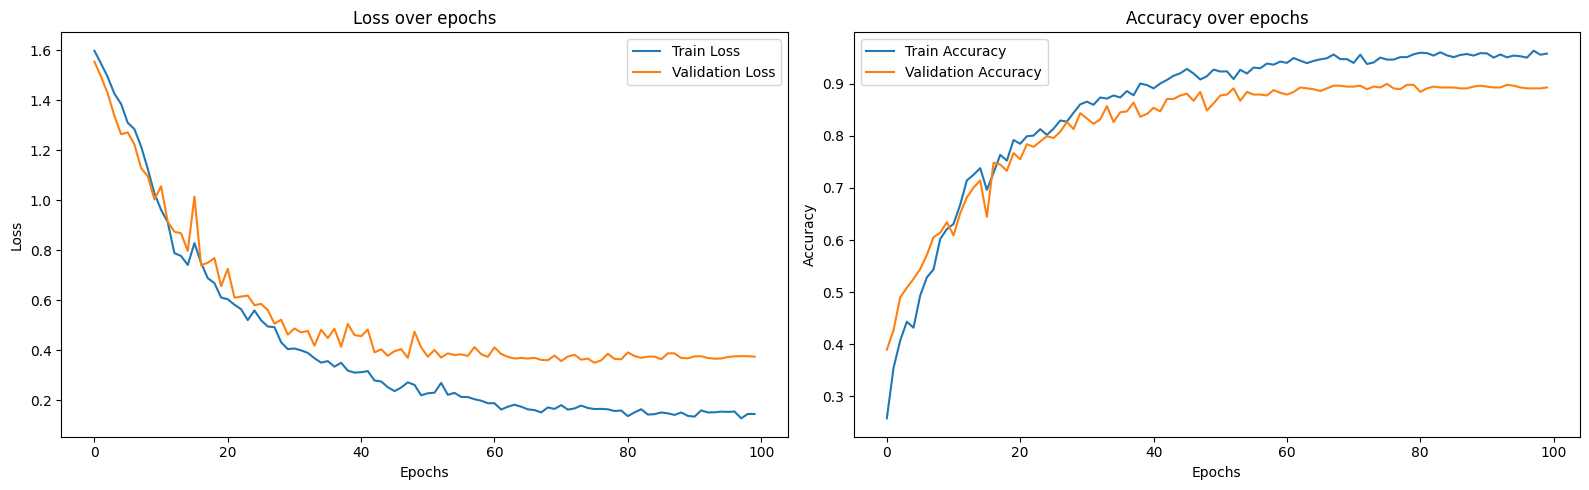

In [20]:
trainer.plot_training_history()

In [25]:
trainer.save_model("./s_model.pt")

Model saved to ./s_model.pt


Train bigger model

In [26]:
EMBED_DIM = 64
HIDDEN_DIM = 128
DROPOUT_P = 0.2

sb_model = SimpleRNNClassifier(vocab_size, EMBED_DIM, HIDDEN_DIM, num_classes, DROPOUT_P).to(device)

In [27]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(sb_model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

trainer = Trainer(sb_model, criterion, optimizer, scheduler=scheduler, device=device)

In [28]:
trainer.train(sampled_train_loader, val_loader, epochs=100)

Epoch 1/100: 100%|██████████| 10/10 [01:36<00:00,  9.65s/it]


Epoch 1/100 | Train Loss: 1.5544 | Train Acc: 0.3228 | Val Loss: 1.4345 | Val Acc: 0.4320 | LR: 0.001000


Epoch 2/100: 100%|██████████| 10/10 [01:12<00:00,  7.25s/it]


Epoch 2/100 | Train Loss: 1.4465 | Train Acc: 0.4134 | Val Loss: 1.3650 | Val Acc: 0.4473 | LR: 0.001000


Epoch 3/100: 100%|██████████| 10/10 [01:15<00:00,  7.52s/it]


Epoch 3/100 | Train Loss: 1.3114 | Train Acc: 0.5023 | Val Loss: 1.3025 | Val Acc: 0.4626 | LR: 0.001000


Epoch 4/100: 100%|██████████| 10/10 [01:02<00:00,  6.22s/it]


Epoch 4/100 | Train Loss: 1.2204 | Train Acc: 0.5274 | Val Loss: 1.1665 | Val Acc: 0.5816 | LR: 0.001000


Epoch 5/100: 100%|██████████| 10/10 [01:11<00:00,  7.16s/it]


Epoch 5/100 | Train Loss: 1.0840 | Train Acc: 0.5832 | Val Loss: 1.1486 | Val Acc: 0.5697 | LR: 0.001000


Epoch 6/100: 100%|██████████| 10/10 [01:06<00:00,  6.62s/it]


Epoch 6/100 | Train Loss: 0.9267 | Train Acc: 0.6538 | Val Loss: 0.9429 | Val Acc: 0.6701 | LR: 0.001000


Epoch 7/100: 100%|██████████| 10/10 [01:13<00:00,  7.39s/it]


Epoch 7/100 | Train Loss: 0.8460 | Train Acc: 0.6827 | Val Loss: 0.9804 | Val Acc: 0.6599 | LR: 0.001000


Epoch 8/100: 100%|██████████| 10/10 [01:08<00:00,  6.83s/it]


Epoch 8/100 | Train Loss: 0.8014 | Train Acc: 0.7095 | Val Loss: 0.8580 | Val Acc: 0.6973 | LR: 0.001000


Epoch 9/100: 100%|██████████| 10/10 [01:07<00:00,  6.75s/it]


Epoch 9/100 | Train Loss: 0.7612 | Train Acc: 0.7303 | Val Loss: 0.8644 | Val Acc: 0.6769 | LR: 0.001000


Epoch 10/100: 100%|██████████| 10/10 [01:06<00:00,  6.66s/it]


Epoch 10/100 | Train Loss: 0.6865 | Train Acc: 0.7520 | Val Loss: 0.7081 | Val Acc: 0.7551 | LR: 0.001000


Epoch 11/100: 100%|██████████| 10/10 [01:08<00:00,  6.86s/it]


Epoch 11/100 | Train Loss: 0.6261 | Train Acc: 0.7741 | Val Loss: 0.7933 | Val Acc: 0.6973 | LR: 0.001000


Epoch 12/100: 100%|██████████| 10/10 [01:11<00:00,  7.16s/it]


Epoch 12/100 | Train Loss: 0.5378 | Train Acc: 0.8107 | Val Loss: 0.6626 | Val Acc: 0.7636 | LR: 0.001000


Epoch 13/100: 100%|██████████| 10/10 [01:15<00:00,  7.52s/it]


Epoch 13/100 | Train Loss: 0.5072 | Train Acc: 0.8197 | Val Loss: 0.6173 | Val Acc: 0.7874 | LR: 0.001000


Epoch 14/100: 100%|██████████| 10/10 [01:11<00:00,  7.11s/it]


Epoch 14/100 | Train Loss: 0.4897 | Train Acc: 0.8282 | Val Loss: 0.5602 | Val Acc: 0.8112 | LR: 0.001000


Epoch 15/100: 100%|██████████| 10/10 [01:13<00:00,  7.30s/it]


Epoch 15/100 | Train Loss: 0.4100 | Train Acc: 0.8567 | Val Loss: 0.6107 | Val Acc: 0.7993 | LR: 0.001000


Epoch 16/100: 100%|██████████| 10/10 [01:19<00:00,  7.95s/it]


Epoch 16/100 | Train Loss: 0.4284 | Train Acc: 0.8554 | Val Loss: 0.5894 | Val Acc: 0.8180 | LR: 0.001000


Epoch 17/100: 100%|██████████| 10/10 [01:08<00:00,  6.87s/it]


Epoch 17/100 | Train Loss: 0.3722 | Train Acc: 0.8686 | Val Loss: 0.5574 | Val Acc: 0.8112 | LR: 0.001000


Epoch 18/100: 100%|██████████| 10/10 [01:18<00:00,  7.90s/it]


Epoch 18/100 | Train Loss: 0.3444 | Train Acc: 0.8715 | Val Loss: 0.6132 | Val Acc: 0.7925 | LR: 0.001000


Epoch 19/100: 100%|██████████| 10/10 [00:57<00:00,  5.80s/it]


Epoch 19/100 | Train Loss: 0.3671 | Train Acc: 0.8711 | Val Loss: 0.6008 | Val Acc: 0.8061 | LR: 0.001000


Epoch 20/100: 100%|██████████| 10/10 [01:05<00:00,  6.59s/it]


Epoch 20/100 | Train Loss: 0.3046 | Train Acc: 0.9022 | Val Loss: 0.5085 | Val Acc: 0.8554 | LR: 0.001000


Epoch 21/100: 100%|██████████| 10/10 [01:21<00:00,  8.14s/it]


Epoch 21/100 | Train Loss: 0.2971 | Train Acc: 0.8979 | Val Loss: 0.4056 | Val Acc: 0.8793 | LR: 0.001000


Epoch 22/100: 100%|██████████| 10/10 [01:17<00:00,  7.80s/it]


Epoch 22/100 | Train Loss: 0.2439 | Train Acc: 0.9166 | Val Loss: 0.4226 | Val Acc: 0.8690 | LR: 0.001000


Epoch 23/100: 100%|██████████| 10/10 [01:21<00:00,  8.10s/it]


Epoch 23/100 | Train Loss: 0.2665 | Train Acc: 0.9107 | Val Loss: 0.3976 | Val Acc: 0.8844 | LR: 0.001000


Epoch 24/100: 100%|██████████| 10/10 [01:15<00:00,  7.54s/it]


Epoch 24/100 | Train Loss: 0.2303 | Train Acc: 0.9213 | Val Loss: 0.3788 | Val Acc: 0.8912 | LR: 0.001000


Epoch 25/100: 100%|██████████| 10/10 [01:15<00:00,  7.52s/it]


Epoch 25/100 | Train Loss: 0.2237 | Train Acc: 0.9302 | Val Loss: 0.3987 | Val Acc: 0.8861 | LR: 0.001000


Epoch 26/100: 100%|██████████| 10/10 [01:08<00:00,  6.90s/it]


Epoch 26/100 | Train Loss: 0.2087 | Train Acc: 0.9277 | Val Loss: 0.3833 | Val Acc: 0.8827 | LR: 0.001000


Epoch 27/100: 100%|██████████| 10/10 [01:10<00:00,  7.01s/it]


Epoch 27/100 | Train Loss: 0.1992 | Train Acc: 0.9324 | Val Loss: 0.3802 | Val Acc: 0.8861 | LR: 0.001000


Epoch 28/100: 100%|██████████| 10/10 [01:17<00:00,  7.73s/it]


Epoch 28/100 | Train Loss: 0.1862 | Train Acc: 0.9400 | Val Loss: 0.3825 | Val Acc: 0.8878 | LR: 0.001000


Epoch 29/100: 100%|██████████| 10/10 [01:20<00:00,  8.04s/it]


Epoch 29/100 | Train Loss: 0.1698 | Train Acc: 0.9447 | Val Loss: 0.4189 | Val Acc: 0.8878 | LR: 0.001000


Epoch 30/100: 100%|██████████| 10/10 [01:17<00:00,  7.77s/it]


Epoch 30/100 | Train Loss: 0.1548 | Train Acc: 0.9519 | Val Loss: 0.4294 | Val Acc: 0.8793 | LR: 0.000500


Epoch 31/100: 100%|██████████| 10/10 [01:19<00:00,  7.96s/it]


Epoch 31/100 | Train Loss: 0.1408 | Train Acc: 0.9562 | Val Loss: 0.3842 | Val Acc: 0.8912 | LR: 0.000500


Epoch 32/100: 100%|██████████| 10/10 [01:12<00:00,  7.28s/it]


Epoch 32/100 | Train Loss: 0.1406 | Train Acc: 0.9617 | Val Loss: 0.4124 | Val Acc: 0.8878 | LR: 0.000500


Epoch 33/100: 100%|██████████| 10/10 [01:19<00:00,  7.90s/it]


Epoch 33/100 | Train Loss: 0.1208 | Train Acc: 0.9677 | Val Loss: 0.4489 | Val Acc: 0.8741 | LR: 0.000500


Epoch 34/100: 100%|██████████| 10/10 [01:09<00:00,  6.94s/it]


Epoch 34/100 | Train Loss: 0.1295 | Train Acc: 0.9600 | Val Loss: 0.4098 | Val Acc: 0.8878 | LR: 0.000500


Epoch 35/100: 100%|██████████| 10/10 [01:11<00:00,  7.15s/it]


Epoch 35/100 | Train Loss: 0.1181 | Train Acc: 0.9647 | Val Loss: 0.4179 | Val Acc: 0.8895 | LR: 0.000500


Epoch 36/100: 100%|██████████| 10/10 [01:16<00:00,  7.60s/it]


Epoch 36/100 | Train Loss: 0.1218 | Train Acc: 0.9604 | Val Loss: 0.4257 | Val Acc: 0.8827 | LR: 0.000250


Epoch 37/100: 100%|██████████| 10/10 [01:09<00:00,  6.92s/it]


Epoch 37/100 | Train Loss: 0.1256 | Train Acc: 0.9626 | Val Loss: 0.4001 | Val Acc: 0.8878 | LR: 0.000250


Epoch 38/100: 100%|██████████| 10/10 [01:08<00:00,  6.83s/it]


Epoch 38/100 | Train Loss: 0.1077 | Train Acc: 0.9655 | Val Loss: 0.4055 | Val Acc: 0.8810 | LR: 0.000250


Epoch 39/100: 100%|██████████| 10/10 [01:14<00:00,  7.49s/it]


Epoch 39/100 | Train Loss: 0.1016 | Train Acc: 0.9707 | Val Loss: 0.3945 | Val Acc: 0.8929 | LR: 0.000250


Epoch 40/100: 100%|██████████| 10/10 [01:18<00:00,  7.88s/it]


Epoch 40/100 | Train Loss: 0.0926 | Train Acc: 0.9724 | Val Loss: 0.4057 | Val Acc: 0.8793 | LR: 0.000250


Epoch 41/100: 100%|██████████| 10/10 [01:17<00:00,  7.76s/it]


Epoch 41/100 | Train Loss: 0.1031 | Train Acc: 0.9698 | Val Loss: 0.4132 | Val Acc: 0.8793 | LR: 0.000250


Epoch 42/100: 100%|██████████| 10/10 [01:22<00:00,  8.24s/it]


Epoch 42/100 | Train Loss: 0.0911 | Train Acc: 0.9745 | Val Loss: 0.4355 | Val Acc: 0.8776 | LR: 0.000125


Epoch 43/100: 100%|██████████| 10/10 [01:13<00:00,  7.33s/it]


Epoch 43/100 | Train Loss: 0.1044 | Train Acc: 0.9685 | Val Loss: 0.3922 | Val Acc: 0.8861 | LR: 0.000125


Epoch 44/100: 100%|██████████| 10/10 [01:16<00:00,  7.64s/it]


Epoch 44/100 | Train Loss: 0.0907 | Train Acc: 0.9707 | Val Loss: 0.4034 | Val Acc: 0.8844 | LR: 0.000125


Epoch 45/100: 100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Epoch 45/100 | Train Loss: 0.0979 | Train Acc: 0.9711 | Val Loss: 0.4302 | Val Acc: 0.8776 | LR: 0.000125


Epoch 46/100: 100%|██████████| 10/10 [01:03<00:00,  6.38s/it]


Epoch 46/100 | Train Loss: 0.0983 | Train Acc: 0.9702 | Val Loss: 0.4270 | Val Acc: 0.8827 | LR: 0.000125


Epoch 47/100: 100%|██████████| 10/10 [01:15<00:00,  7.55s/it]


Epoch 47/100 | Train Loss: 0.0895 | Train Acc: 0.9719 | Val Loss: 0.4128 | Val Acc: 0.8827 | LR: 0.000125


Epoch 48/100: 100%|██████████| 10/10 [01:11<00:00,  7.16s/it]


Epoch 48/100 | Train Loss: 0.0896 | Train Acc: 0.9728 | Val Loss: 0.4215 | Val Acc: 0.8810 | LR: 0.000063


Epoch 49/100: 100%|██████████| 10/10 [01:11<00:00,  7.19s/it]


Epoch 49/100 | Train Loss: 0.0955 | Train Acc: 0.9745 | Val Loss: 0.4210 | Val Acc: 0.8793 | LR: 0.000063


Epoch 50/100: 100%|██████████| 10/10 [01:13<00:00,  7.39s/it]


Epoch 50/100 | Train Loss: 0.0988 | Train Acc: 0.9689 | Val Loss: 0.4169 | Val Acc: 0.8861 | LR: 0.000063


Epoch 51/100: 100%|██████████| 10/10 [01:19<00:00,  7.97s/it]


Epoch 51/100 | Train Loss: 0.0831 | Train Acc: 0.9796 | Val Loss: 0.4197 | Val Acc: 0.8810 | LR: 0.000063


Epoch 52/100: 100%|██████████| 10/10 [01:15<00:00,  7.55s/it]


Epoch 52/100 | Train Loss: 0.0888 | Train Acc: 0.9707 | Val Loss: 0.4217 | Val Acc: 0.8827 | LR: 0.000063


Epoch 53/100: 100%|██████████| 10/10 [01:15<00:00,  7.54s/it]


Epoch 53/100 | Train Loss: 0.0879 | Train Acc: 0.9753 | Val Loss: 0.4215 | Val Acc: 0.8827 | LR: 0.000063


Epoch 54/100: 100%|██████████| 10/10 [01:27<00:00,  8.72s/it]


Epoch 54/100 | Train Loss: 0.0790 | Train Acc: 0.9800 | Val Loss: 0.4090 | Val Acc: 0.8861 | LR: 0.000031


Epoch 55/100: 100%|██████████| 10/10 [01:12<00:00,  7.27s/it]


Epoch 55/100 | Train Loss: 0.0816 | Train Acc: 0.9792 | Val Loss: 0.4074 | Val Acc: 0.8861 | LR: 0.000031


Epoch 56/100: 100%|██████████| 10/10 [01:15<00:00,  7.58s/it]


Epoch 56/100 | Train Loss: 0.0856 | Train Acc: 0.9749 | Val Loss: 0.4082 | Val Acc: 0.8861 | LR: 0.000031


Epoch 57/100: 100%|██████████| 10/10 [01:09<00:00,  6.97s/it]


Epoch 57/100 | Train Loss: 0.0899 | Train Acc: 0.9736 | Val Loss: 0.4160 | Val Acc: 0.8827 | LR: 0.000031


Epoch 58/100: 100%|██████████| 10/10 [01:14<00:00,  7.49s/it]


Epoch 58/100 | Train Loss: 0.0824 | Train Acc: 0.9741 | Val Loss: 0.4209 | Val Acc: 0.8810 | LR: 0.000031


Epoch 59/100: 100%|██████████| 10/10 [01:10<00:00,  7.08s/it]


Epoch 59/100 | Train Loss: 0.0706 | Train Acc: 0.9809 | Val Loss: 0.4132 | Val Acc: 0.8844 | LR: 0.000031


Epoch 60/100: 100%|██████████| 10/10 [01:22<00:00,  8.23s/it]


Epoch 60/100 | Train Loss: 0.0716 | Train Acc: 0.9813 | Val Loss: 0.4145 | Val Acc: 0.8895 | LR: 0.000016


Epoch 61/100: 100%|██████████| 10/10 [01:17<00:00,  7.77s/it]


Epoch 61/100 | Train Loss: 0.0893 | Train Acc: 0.9745 | Val Loss: 0.4176 | Val Acc: 0.8844 | LR: 0.000016


Epoch 62/100: 100%|██████████| 10/10 [01:11<00:00,  7.12s/it]


Epoch 62/100 | Train Loss: 0.0888 | Train Acc: 0.9711 | Val Loss: 0.4221 | Val Acc: 0.8827 | LR: 0.000016


Epoch 63/100: 100%|██████████| 10/10 [01:24<00:00,  8.49s/it]


Epoch 63/100 | Train Loss: 0.0870 | Train Acc: 0.9758 | Val Loss: 0.4194 | Val Acc: 0.8844 | LR: 0.000016


Epoch 64/100: 100%|██████████| 10/10 [01:20<00:00,  8.08s/it]


Epoch 64/100 | Train Loss: 0.0797 | Train Acc: 0.9762 | Val Loss: 0.4128 | Val Acc: 0.8810 | LR: 0.000016


Epoch 65/100: 100%|██████████| 10/10 [01:13<00:00,  7.38s/it]


Epoch 65/100 | Train Loss: 0.0844 | Train Acc: 0.9762 | Val Loss: 0.4106 | Val Acc: 0.8912 | LR: 0.000016


Epoch 66/100: 100%|██████████| 10/10 [01:17<00:00,  7.75s/it]


Epoch 66/100 | Train Loss: 0.0874 | Train Acc: 0.9719 | Val Loss: 0.4110 | Val Acc: 0.8878 | LR: 0.000008


Epoch 67/100: 100%|██████████| 10/10 [01:22<00:00,  8.26s/it]


Epoch 67/100 | Train Loss: 0.0830 | Train Acc: 0.9775 | Val Loss: 0.4112 | Val Acc: 0.8861 | LR: 0.000008


Epoch 68/100: 100%|██████████| 10/10 [01:14<00:00,  7.41s/it]


Epoch 68/100 | Train Loss: 0.0843 | Train Acc: 0.9783 | Val Loss: 0.4112 | Val Acc: 0.8844 | LR: 0.000008


Epoch 69/100: 100%|██████████| 10/10 [01:17<00:00,  7.79s/it]


Epoch 69/100 | Train Loss: 0.0815 | Train Acc: 0.9753 | Val Loss: 0.4112 | Val Acc: 0.8878 | LR: 0.000008


Epoch 70/100: 100%|██████████| 10/10 [01:20<00:00,  8.06s/it]


Epoch 70/100 | Train Loss: 0.0913 | Train Acc: 0.9685 | Val Loss: 0.4127 | Val Acc: 0.8827 | LR: 0.000008


Epoch 71/100: 100%|██████████| 10/10 [01:21<00:00,  8.12s/it]


Epoch 71/100 | Train Loss: 0.0841 | Train Acc: 0.9766 | Val Loss: 0.4137 | Val Acc: 0.8827 | LR: 0.000008


Epoch 72/100: 100%|██████████| 10/10 [01:13<00:00,  7.36s/it]


Epoch 72/100 | Train Loss: 0.0757 | Train Acc: 0.9745 | Val Loss: 0.4155 | Val Acc: 0.8827 | LR: 0.000004


Epoch 73/100: 100%|██████████| 10/10 [01:10<00:00,  7.06s/it]


Epoch 73/100 | Train Loss: 0.0787 | Train Acc: 0.9775 | Val Loss: 0.4165 | Val Acc: 0.8861 | LR: 0.000004


Epoch 74/100: 100%|██████████| 10/10 [01:12<00:00,  7.26s/it]


Epoch 74/100 | Train Loss: 0.0799 | Train Acc: 0.9779 | Val Loss: 0.4168 | Val Acc: 0.8861 | LR: 0.000004


Epoch 75/100: 100%|██████████| 10/10 [01:17<00:00,  7.71s/it]


Epoch 75/100 | Train Loss: 0.0745 | Train Acc: 0.9779 | Val Loss: 0.4156 | Val Acc: 0.8861 | LR: 0.000004


Epoch 76/100: 100%|██████████| 10/10 [01:13<00:00,  7.37s/it]


Epoch 76/100 | Train Loss: 0.0655 | Train Acc: 0.9787 | Val Loss: 0.4149 | Val Acc: 0.8861 | LR: 0.000004


Epoch 77/100: 100%|██████████| 10/10 [01:22<00:00,  8.29s/it]


Epoch 77/100 | Train Loss: 0.0921 | Train Acc: 0.9736 | Val Loss: 0.4144 | Val Acc: 0.8861 | LR: 0.000004


Epoch 78/100: 100%|██████████| 10/10 [01:20<00:00,  8.09s/it]


Epoch 78/100 | Train Loss: 0.0634 | Train Acc: 0.9851 | Val Loss: 0.4142 | Val Acc: 0.8861 | LR: 0.000002


Epoch 79/100: 100%|██████████| 10/10 [01:21<00:00,  8.19s/it]


Epoch 79/100 | Train Loss: 0.0791 | Train Acc: 0.9804 | Val Loss: 0.4140 | Val Acc: 0.8844 | LR: 0.000002


Epoch 80/100: 100%|██████████| 10/10 [01:31<00:00,  9.18s/it]


Epoch 80/100 | Train Loss: 0.0800 | Train Acc: 0.9804 | Val Loss: 0.4138 | Val Acc: 0.8844 | LR: 0.000002


Epoch 81/100: 100%|██████████| 10/10 [01:16<00:00,  7.66s/it]


Epoch 81/100 | Train Loss: 0.0839 | Train Acc: 0.9741 | Val Loss: 0.4135 | Val Acc: 0.8827 | LR: 0.000002


Epoch 82/100: 100%|██████████| 10/10 [01:06<00:00,  6.63s/it]


Epoch 82/100 | Train Loss: 0.0869 | Train Acc: 0.9766 | Val Loss: 0.4134 | Val Acc: 0.8827 | LR: 0.000002


Epoch 83/100: 100%|██████████| 10/10 [01:21<00:00,  8.17s/it]


Epoch 83/100 | Train Loss: 0.0789 | Train Acc: 0.9770 | Val Loss: 0.4135 | Val Acc: 0.8827 | LR: 0.000002


Epoch 84/100: 100%|██████████| 10/10 [01:19<00:00,  7.92s/it]


Epoch 84/100 | Train Loss: 0.0806 | Train Acc: 0.9758 | Val Loss: 0.4137 | Val Acc: 0.8827 | LR: 0.000001


Epoch 85/100: 100%|██████████| 10/10 [01:15<00:00,  7.59s/it]


Epoch 85/100 | Train Loss: 0.0894 | Train Acc: 0.9719 | Val Loss: 0.4136 | Val Acc: 0.8827 | LR: 0.000001


Epoch 86/100: 100%|██████████| 10/10 [01:10<00:00,  7.02s/it]


Epoch 86/100 | Train Loss: 0.0844 | Train Acc: 0.9749 | Val Loss: 0.4137 | Val Acc: 0.8827 | LR: 0.000001


Epoch 87/100: 100%|██████████| 10/10 [01:17<00:00,  7.80s/it]


Epoch 87/100 | Train Loss: 0.0893 | Train Acc: 0.9728 | Val Loss: 0.4139 | Val Acc: 0.8827 | LR: 0.000001


Epoch 88/100: 100%|██████████| 10/10 [01:29<00:00,  8.98s/it]


Epoch 88/100 | Train Loss: 0.0819 | Train Acc: 0.9753 | Val Loss: 0.4140 | Val Acc: 0.8827 | LR: 0.000001


Epoch 89/100: 100%|██████████| 10/10 [01:18<00:00,  7.84s/it]


Epoch 89/100 | Train Loss: 0.0892 | Train Acc: 0.9775 | Val Loss: 0.4140 | Val Acc: 0.8827 | LR: 0.000001


Epoch 90/100: 100%|██████████| 10/10 [01:20<00:00,  8.09s/it]


Epoch 90/100 | Train Loss: 0.0819 | Train Acc: 0.9766 | Val Loss: 0.4140 | Val Acc: 0.8827 | LR: 0.000000


Epoch 91/100: 100%|██████████| 10/10 [01:15<00:00,  7.57s/it]


Epoch 91/100 | Train Loss: 0.0807 | Train Acc: 0.9804 | Val Loss: 0.4140 | Val Acc: 0.8827 | LR: 0.000000


Epoch 92/100: 100%|██████████| 10/10 [01:17<00:00,  7.71s/it]


Epoch 92/100 | Train Loss: 0.0732 | Train Acc: 0.9792 | Val Loss: 0.4140 | Val Acc: 0.8827 | LR: 0.000000


Epoch 93/100: 100%|██████████| 10/10 [01:20<00:00,  8.08s/it]


Epoch 93/100 | Train Loss: 0.0884 | Train Acc: 0.9736 | Val Loss: 0.4140 | Val Acc: 0.8827 | LR: 0.000000


Epoch 94/100: 100%|██████████| 10/10 [01:18<00:00,  7.80s/it]


Epoch 94/100 | Train Loss: 0.0776 | Train Acc: 0.9753 | Val Loss: 0.4141 | Val Acc: 0.8827 | LR: 0.000000


Epoch 95/100: 100%|██████████| 10/10 [01:28<00:00,  8.86s/it]


Epoch 95/100 | Train Loss: 0.0794 | Train Acc: 0.9783 | Val Loss: 0.4141 | Val Acc: 0.8827 | LR: 0.000000


Epoch 96/100: 100%|██████████| 10/10 [01:16<00:00,  7.69s/it]


Epoch 96/100 | Train Loss: 0.0976 | Train Acc: 0.9724 | Val Loss: 0.4141 | Val Acc: 0.8827 | LR: 0.000000


Epoch 97/100: 100%|██████████| 10/10 [01:22<00:00,  8.25s/it]


Epoch 97/100 | Train Loss: 0.0742 | Train Acc: 0.9783 | Val Loss: 0.4141 | Val Acc: 0.8827 | LR: 0.000000


Epoch 98/100: 100%|██████████| 10/10 [01:28<00:00,  8.89s/it]


Epoch 98/100 | Train Loss: 0.0707 | Train Acc: 0.9800 | Val Loss: 0.4141 | Val Acc: 0.8827 | LR: 0.000000


Epoch 99/100: 100%|██████████| 10/10 [01:17<00:00,  7.73s/it]


Epoch 99/100 | Train Loss: 0.0626 | Train Acc: 0.9868 | Val Loss: 0.4142 | Val Acc: 0.8827 | LR: 0.000000


Epoch 100/100: 100%|██████████| 10/10 [01:15<00:00,  7.58s/it]


Epoch 100/100 | Train Loss: 0.0834 | Train Acc: 0.9758 | Val Loss: 0.4142 | Val Acc: 0.8810 | LR: 0.000000


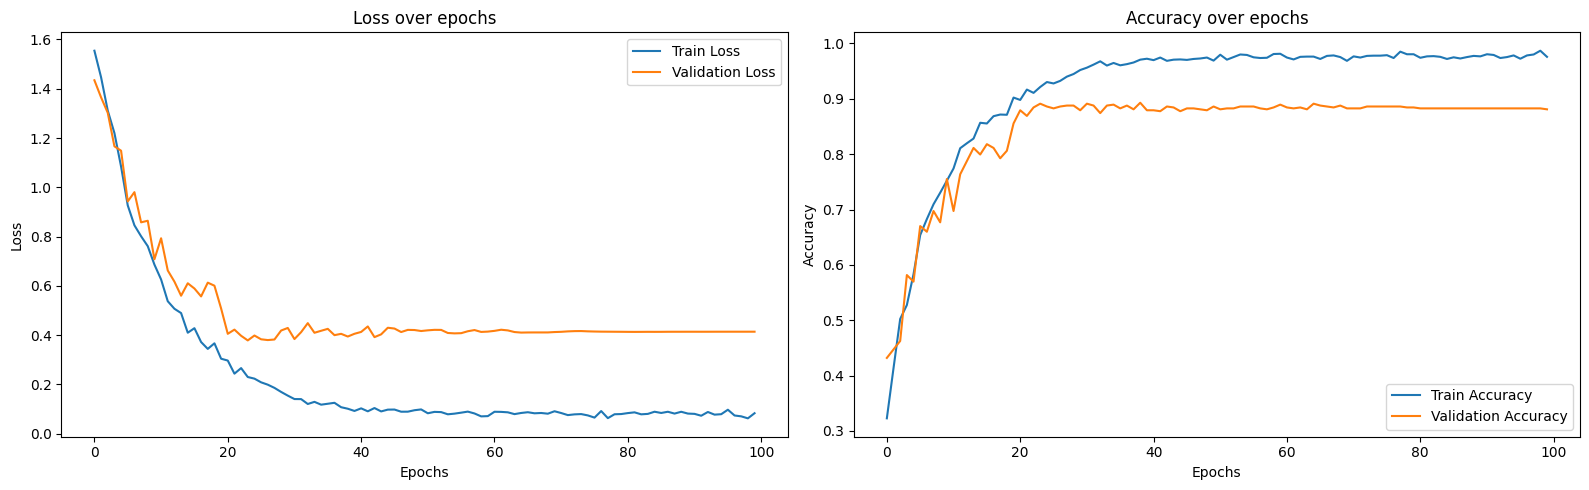

In [29]:
trainer.plot_training_history()

In [31]:
trainer.save_model("./sb_model.pt")

Model saved to ./sb_model.pt


## Evaluate the results

Check the true and false positives per class

In [21]:
from evaluation import predict, plot_true_false_positives

In [23]:
wb_preds, true_labels = predict(wb_model, val_loader, device)

NameError: name 'torch' is not defined

Print confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[compositors[i] for i in range(num_classes)])
disp.plot(ax=ax, cmap='Blues', colorbar=True)
plt.title('Confusion Matrix on Validation Set')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()